Biel González Garriga NIU:1551813

Cristina Soler Arenys NIU:1603542

Judit Panisello Lozano NIU:1605512

https://github.com/Zynokrex/Regressio_APC

In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D
import random
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
def load_dataset(path):
    df = pd.read_csv(path, header=0, delimiter=',')
    return df

dfo = load_dataset('forestfires.csv')
df=dfo.copy()
data = df.values

# Apartat(C): Analitzant Dades

In [3]:
print("Dimensionalitat de la BBDD:", df.shape)

Dimensionalitat de la BBDD: (517, 13)


Veiem que tenim 517 entrades al dataset i que cada entrada te 13 atributs

Les entrades tenen el següent aspecte:

In [4]:
df.head() 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Ara procedim a fer un analisi rapid de les nostres dades:

In [5]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Veiem que tenim variables espacials, X i Y, llavors farem un grafic per veure l'area cremada total a cada coordenada del dataframe

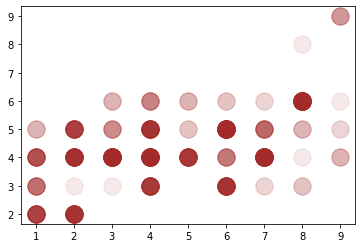

In [6]:
plt.scatter(df['X'].values,df['Y'].values,alpha=0.1, s=300, color='brown')

Farem un recompte dels incendis amb els mesos i els dies i despres mirarem la proporció total entre els mesos, ja que ens pot aportar informació interessant sobre els incendis

In [7]:
target='area'
dfa = df.drop(columns=target)
mt_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

mt_columns, num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

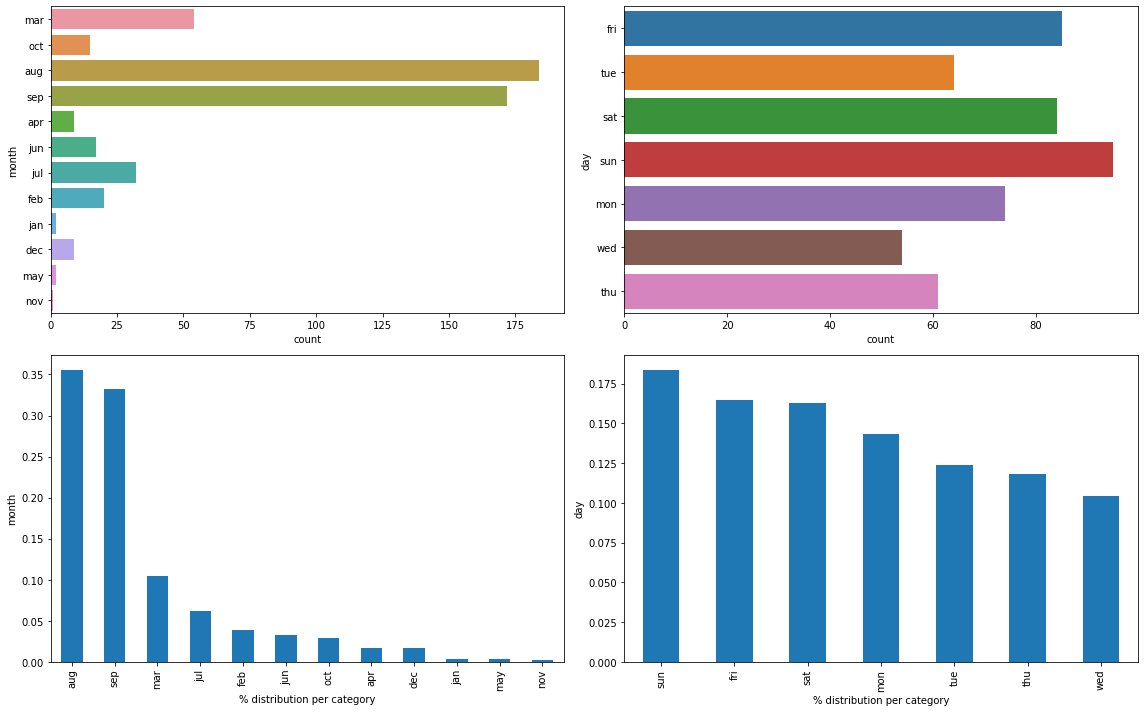

In [8]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(mt_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show() 

Ara farem una escala per classificar la gravetat dels incendis i poder observar com es distribueixen al nostre dataframe

In [9]:
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


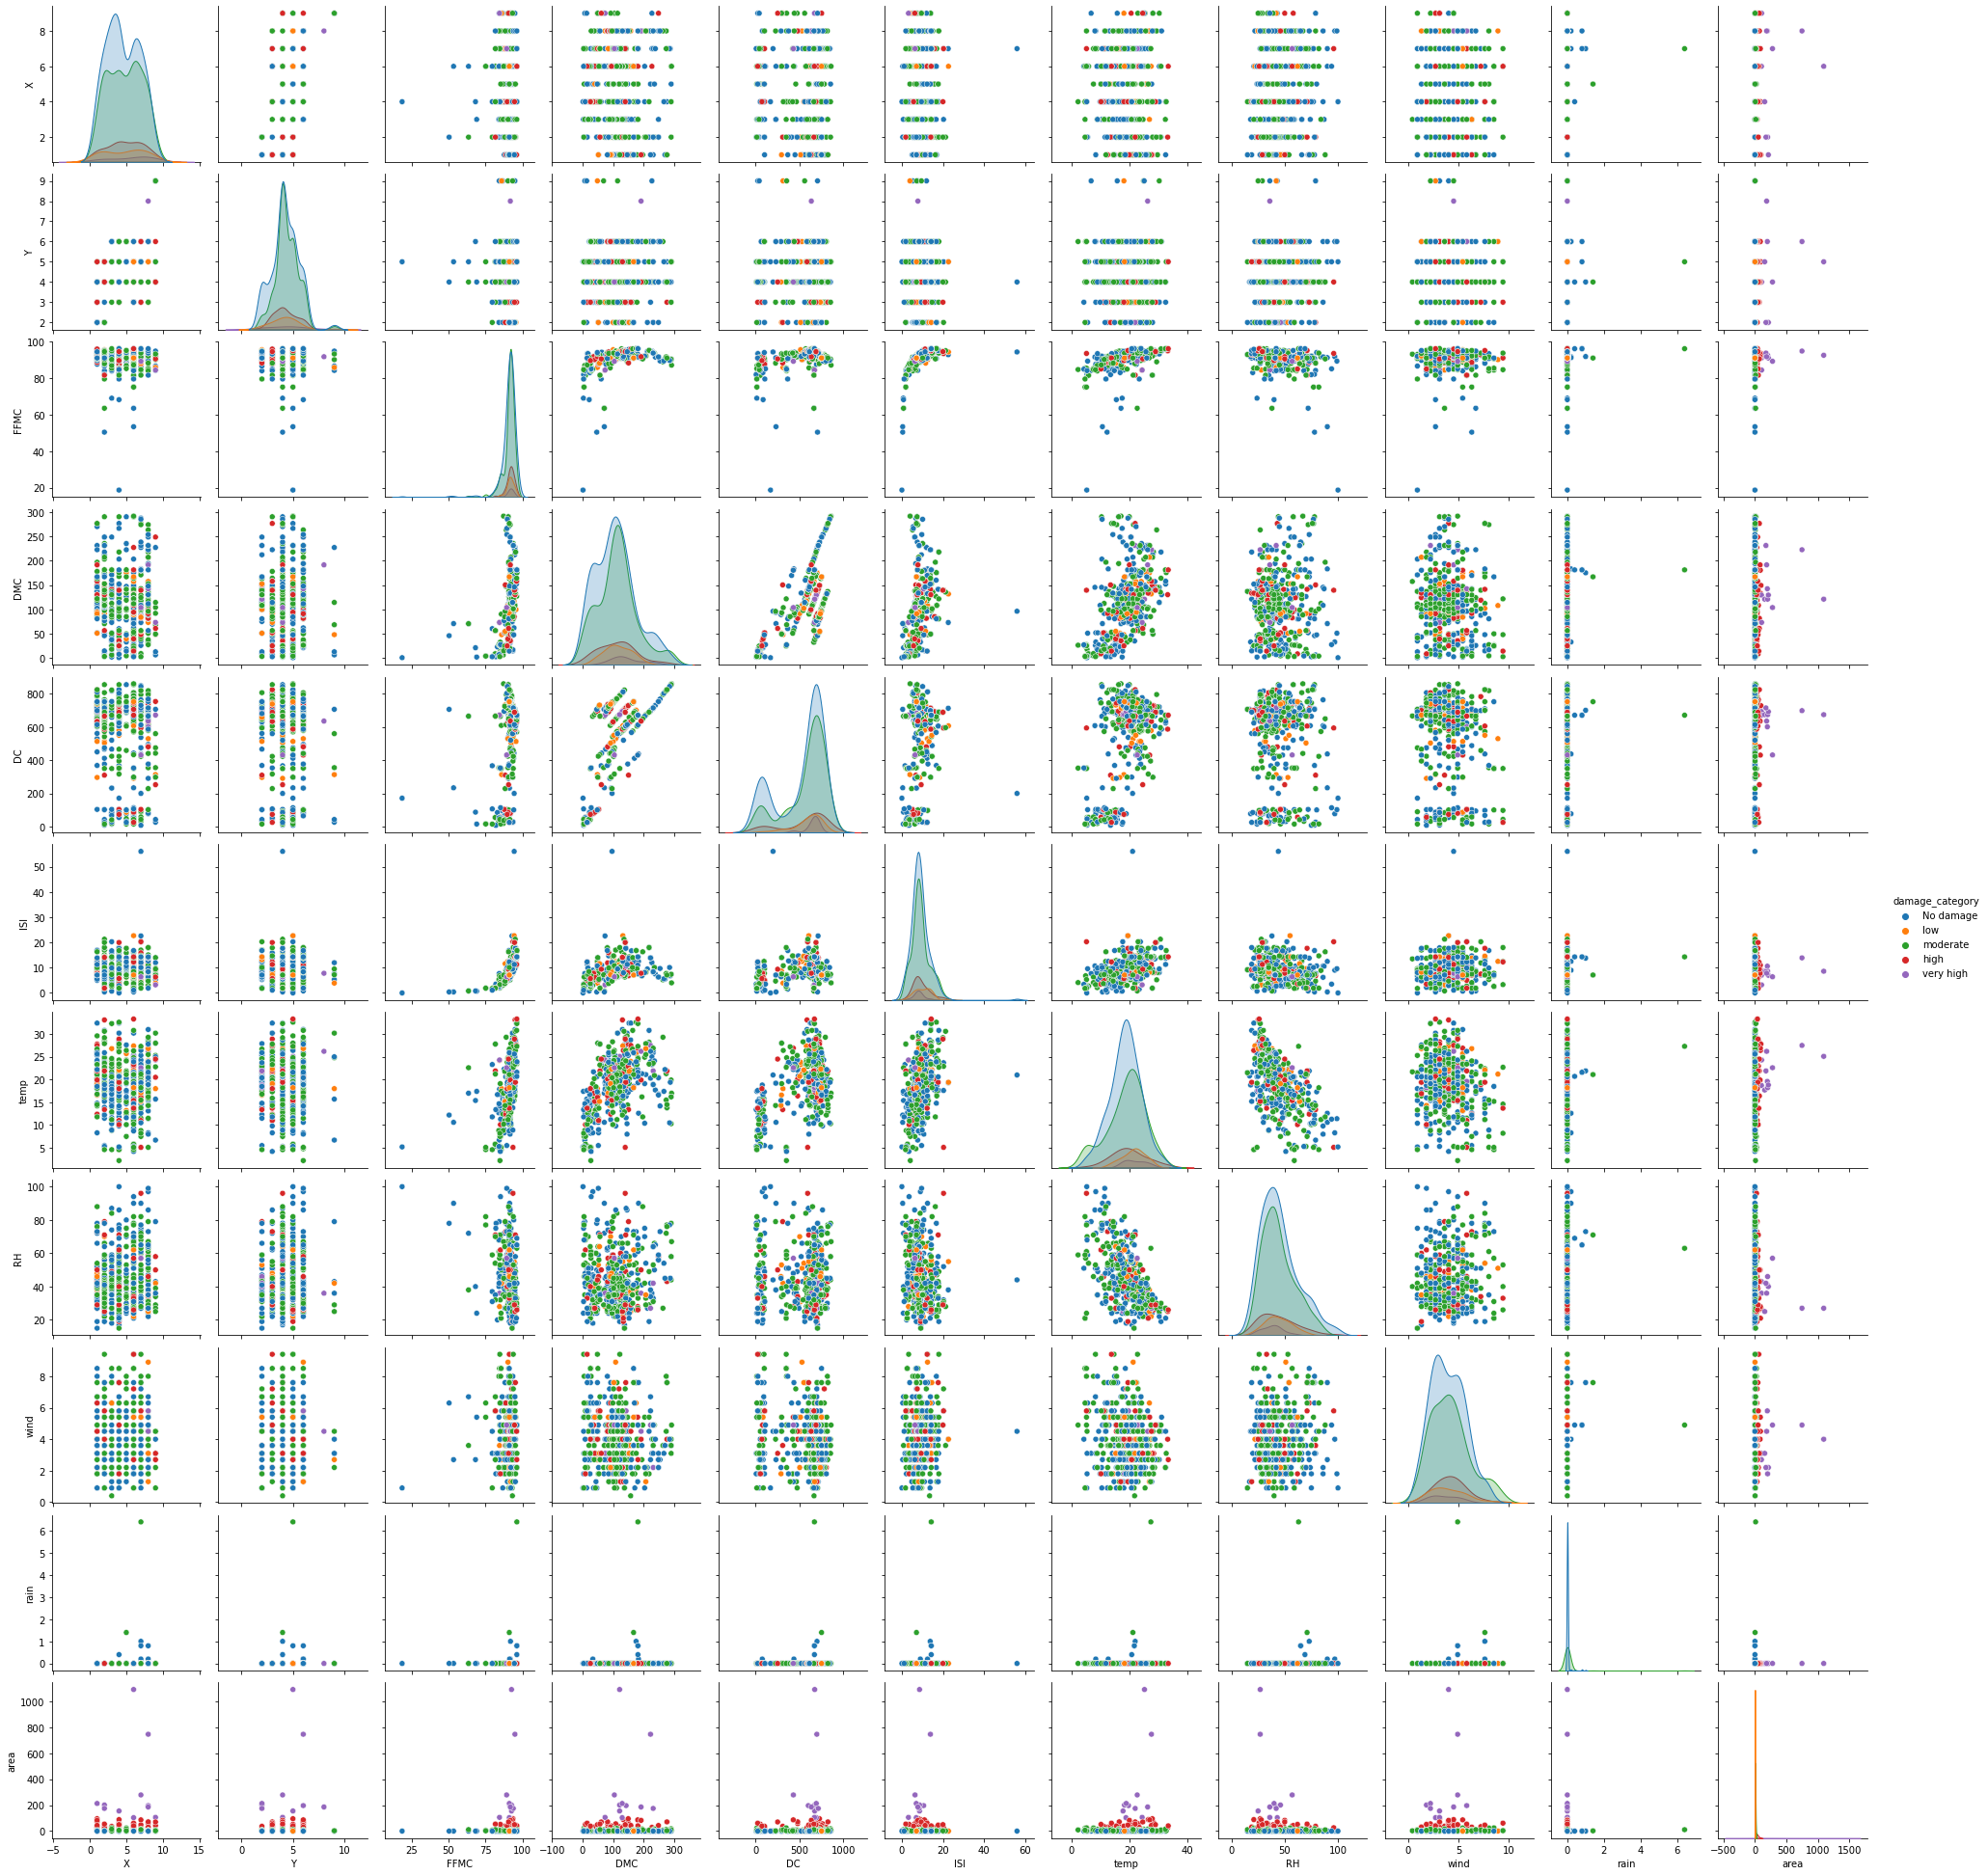

In [10]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features
sns.pairplot(df,hue='damage_category',vars=selected_features)
plt.show()

## Neteja del dataset

Primer mirem si tenim valors nuls

In [11]:
df.isnull().sum()

X                  0
Y                  0
month              0
day                0
FFMC               0
DMC                0
DC                 0
ISI                0
temp               0
RH                 0
wind               0
rain               0
area               0
damage_category    0
dtype: int64

Veiem que no hi ha valors nulls i que per tant per aquesta banda ja hem acabat. Així que seguirem revisant els outliers del dataset per veure si s'ha de treure cap entrada que contingui errors

Ara transformarem els mesos i dies de strings a ints per poder processar-los amb la resta de dades

In [12]:
df['month'].unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

In [13]:
df=df.replace(df['month'].unique(),[3,10,8,9,4,6,7,2,1,12,5,11]).replace(df['day'].unique(),[5,2,6,7,1,3,4])

array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'FFMC'}>,
        <AxesSubplot:title={'center':'DMC'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'ISI'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'wind'}>,
        <AxesSubplot:title={'center':'rain'}>],
       [<AxesSubplot:title={'center':'area'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

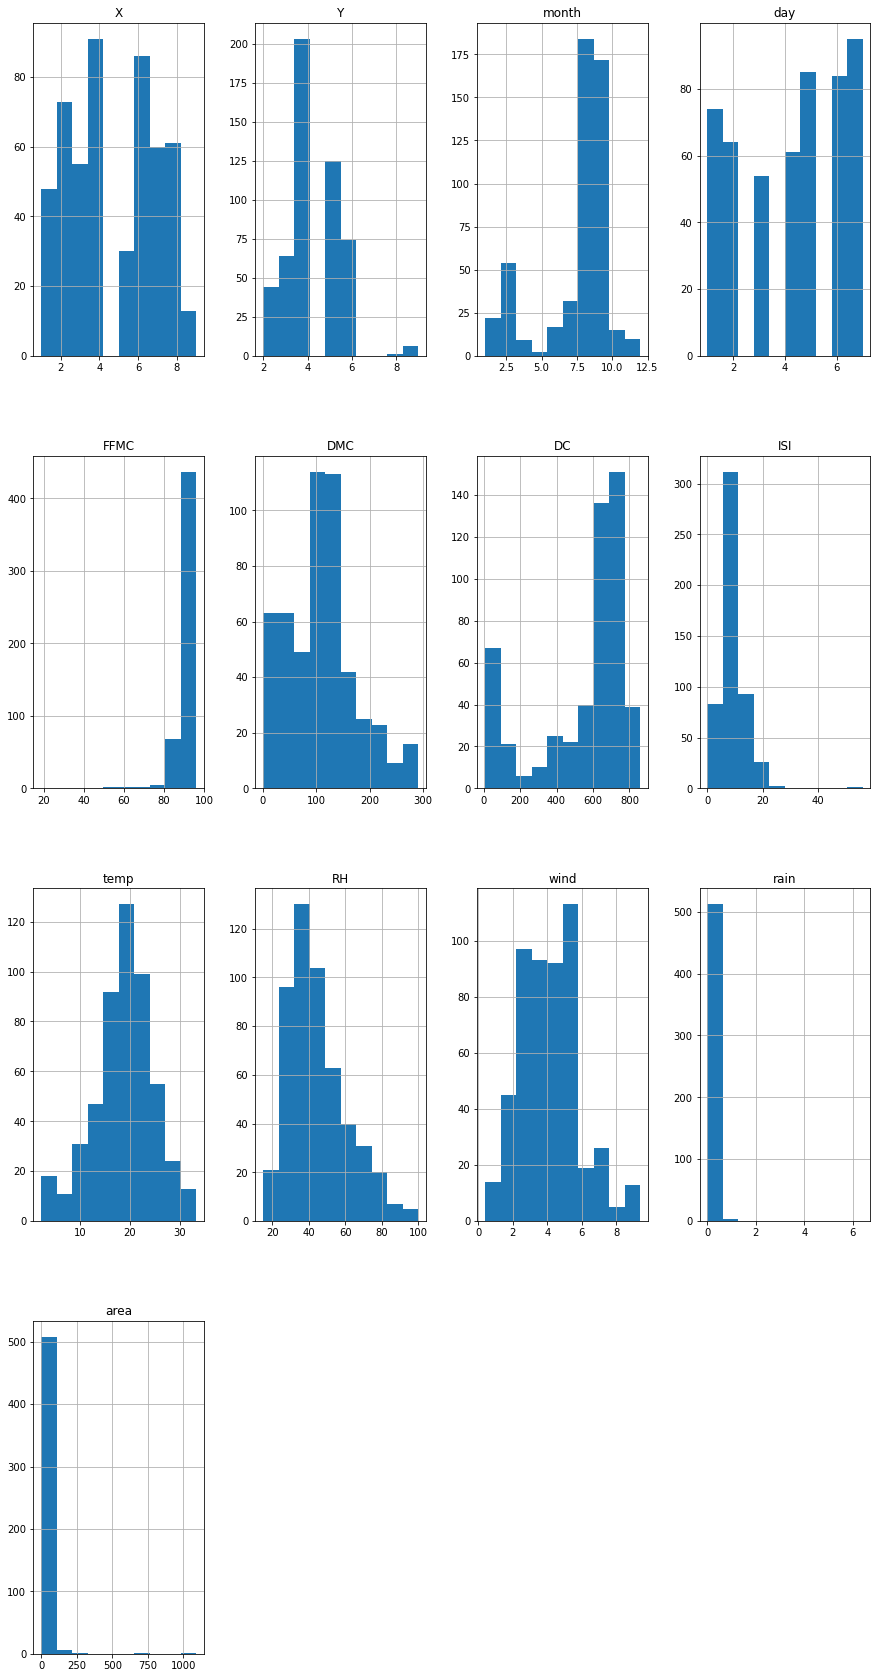

In [14]:
df.hist(figsize=(15,30))

Veiem que tenim outliers en diverses gràfiques: Rain, area, ISI, FFMC. Tot i així no els podem treure del dataset ja que no son errors de mesura son dies mesurats amb condicions mes extremes.

## Anàlisi de correlació

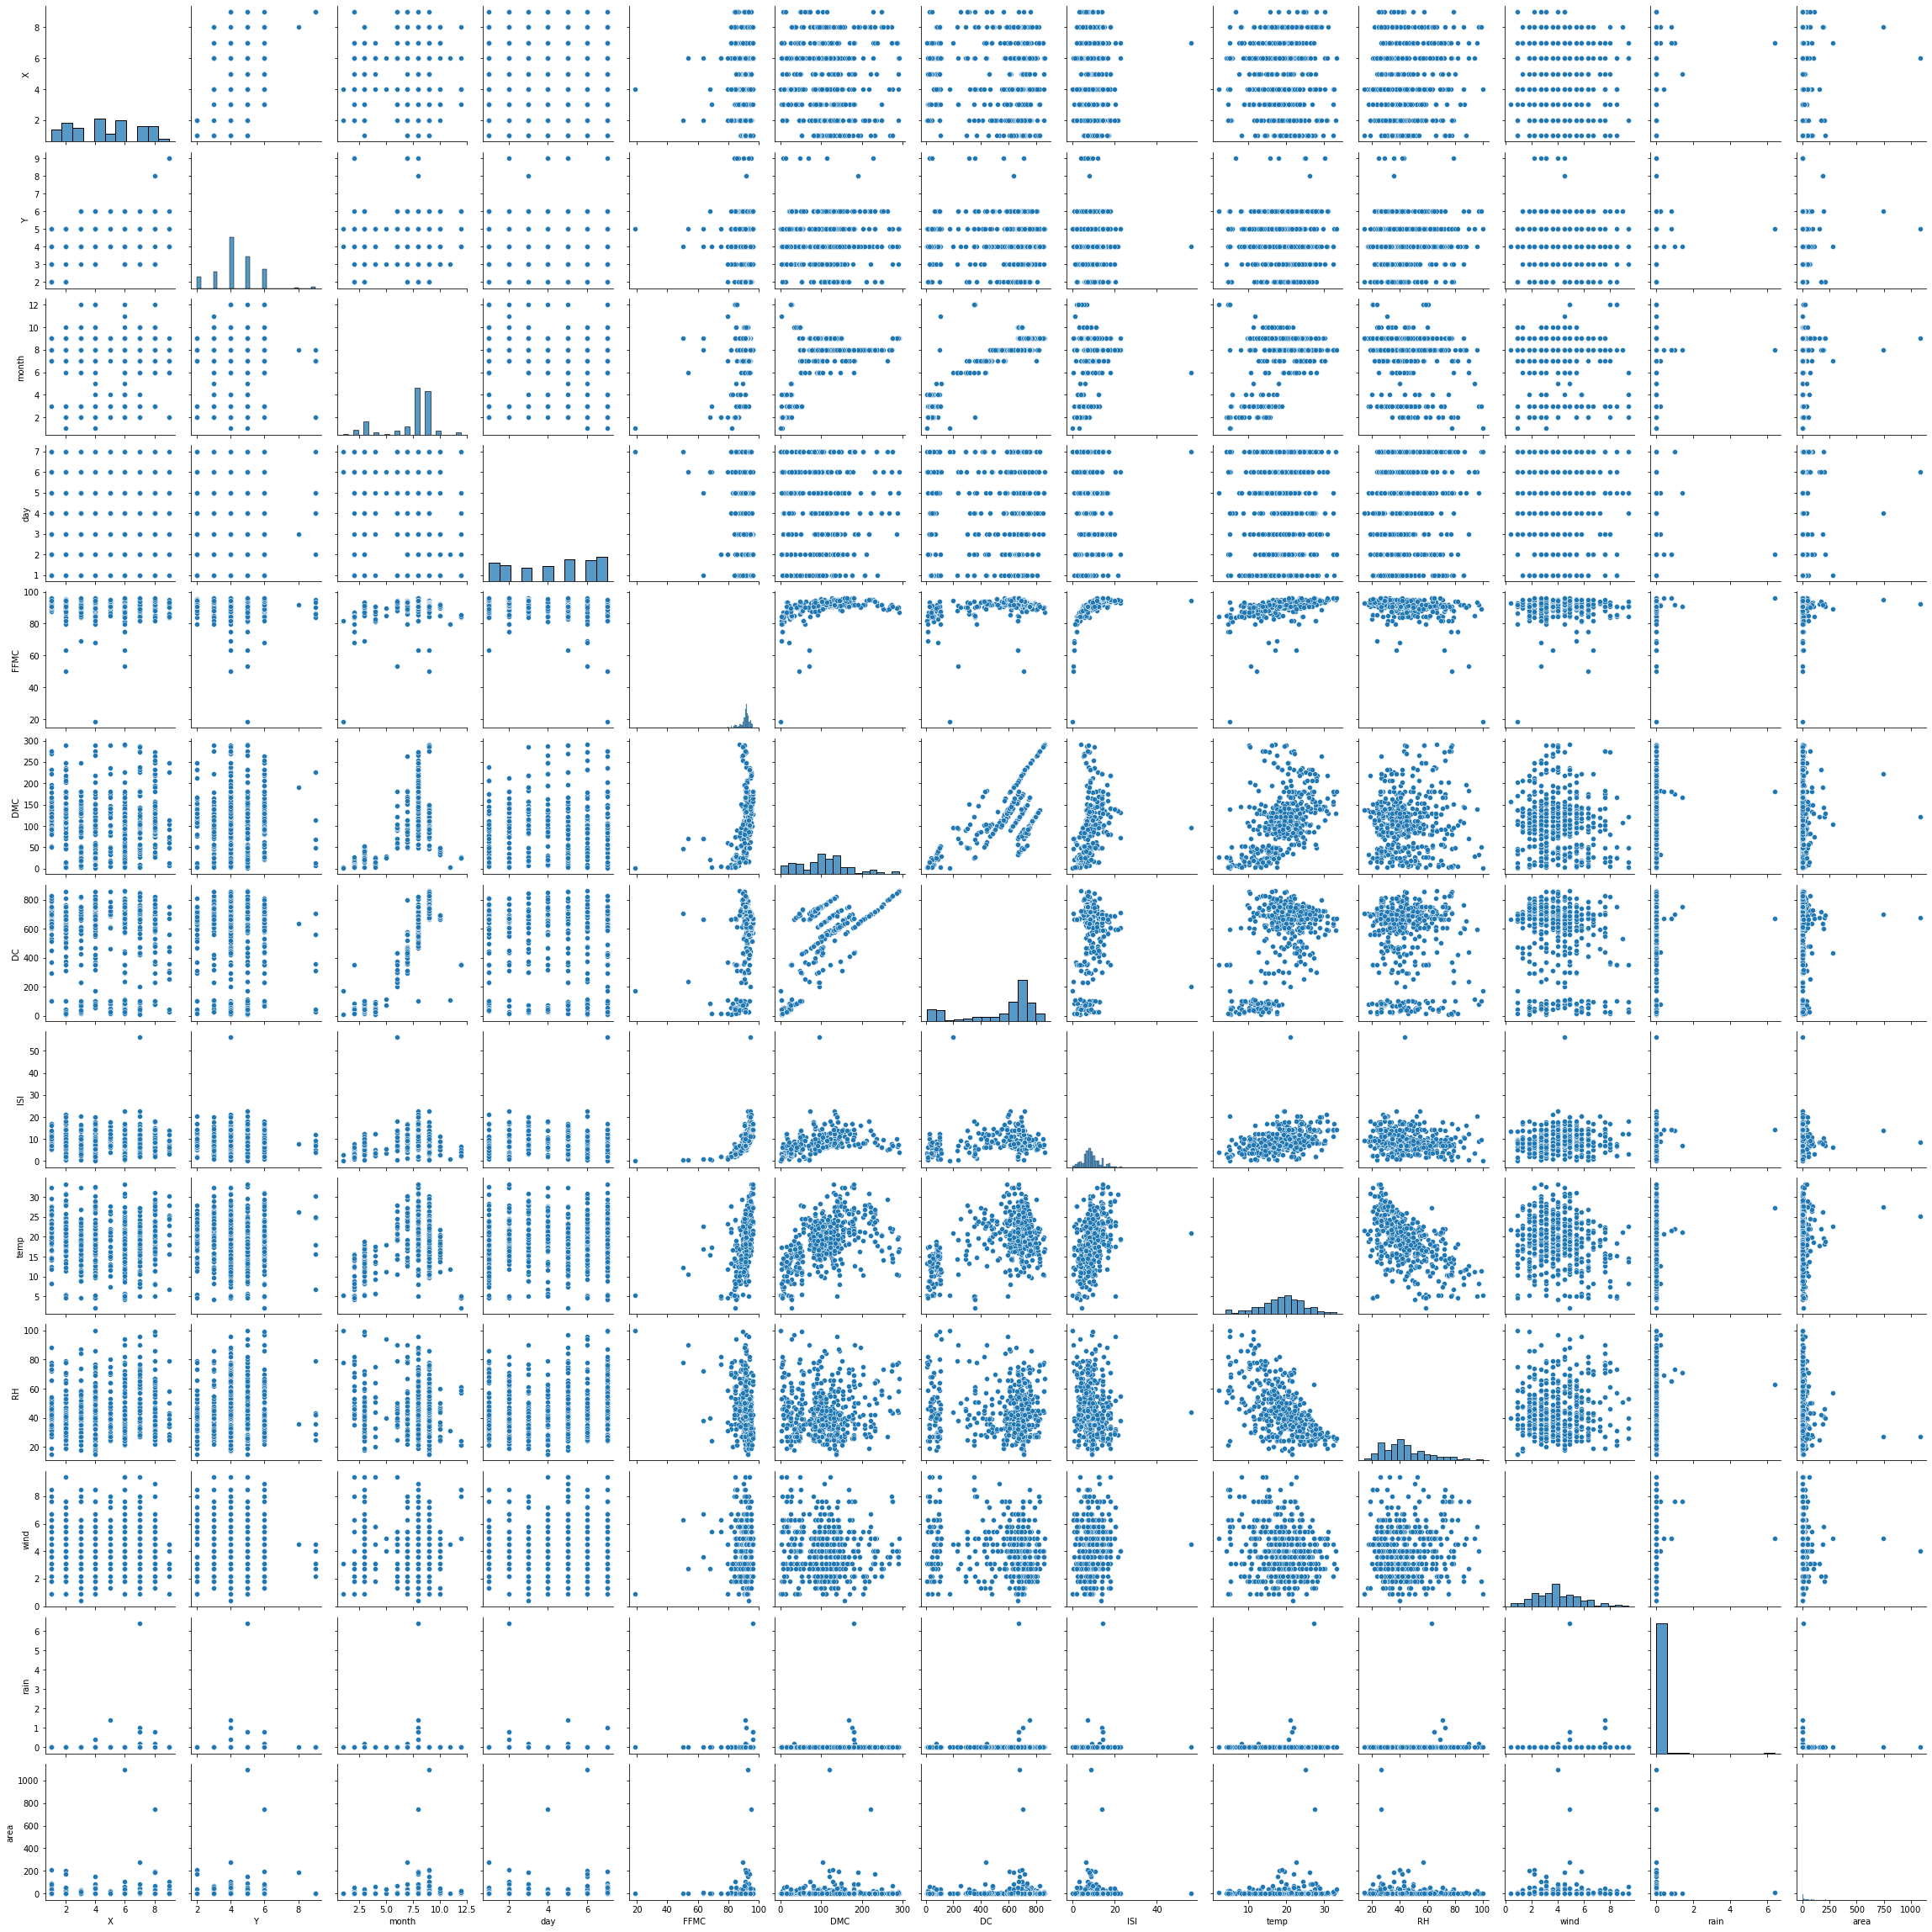

In [15]:
pairPlt = sns.pairplot(df)

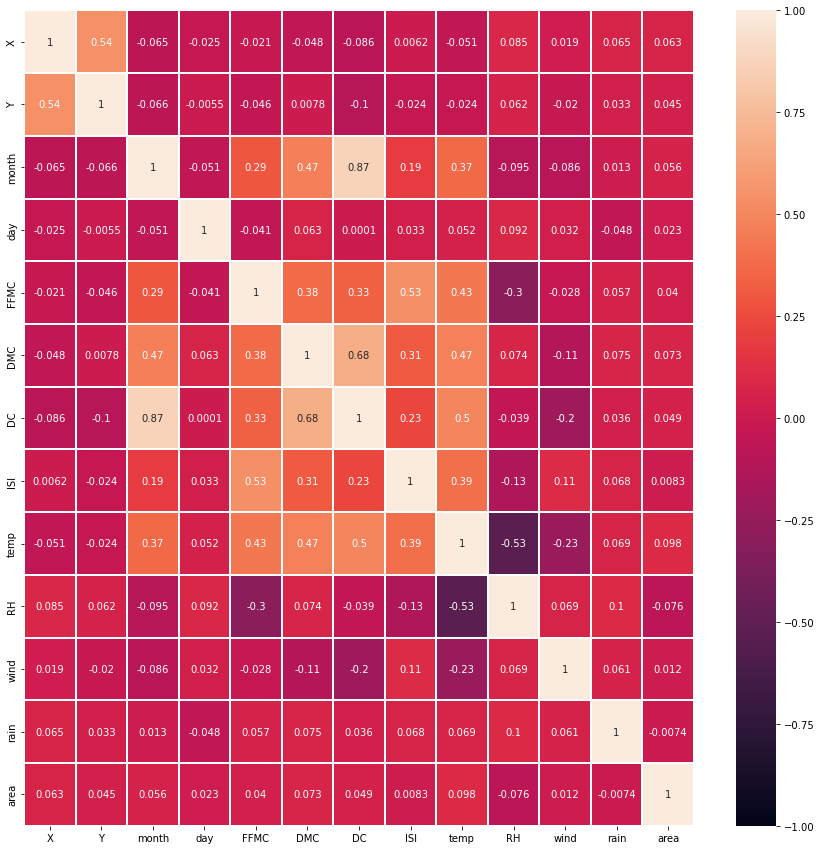

In [16]:
corr=df.corr()
plt.figure(figsize=(15,15))
ax=sns.heatmap(corr,annot=True,linewidth=2,vmin=-1.0,vmax=1.0)

El nostre atribut objectiu, com especificarem despres és l'area, i aquí tenim la correlació amb la resta d'atributs del dataframe

In [17]:
corr["area"]

X        0.063385
Y        0.044873
month    0.056496
day      0.023226
FFMC     0.040122
DMC      0.072994
DC       0.049383
ISI      0.008258
temp     0.097844
RH      -0.075519
wind     0.012317
rain    -0.007366
area     1.000000
Name: area, dtype: float64

## Preguntes

### 1.1 Classes de les variables

Tenim 13 variables diferents per a cada entrada de la base de dades i son dels següents tipus:

In [18]:
df.dtypes

X                    int64
Y                    int64
month                int64
day                  int64
FFMC               float64
DMC                float64
DC                 float64
ISI                float64
temp               float64
RH                   int64
wind               float64
rain               float64
area               float64
damage_category     object
dtype: object

### 1.2 Possibles gaussianes

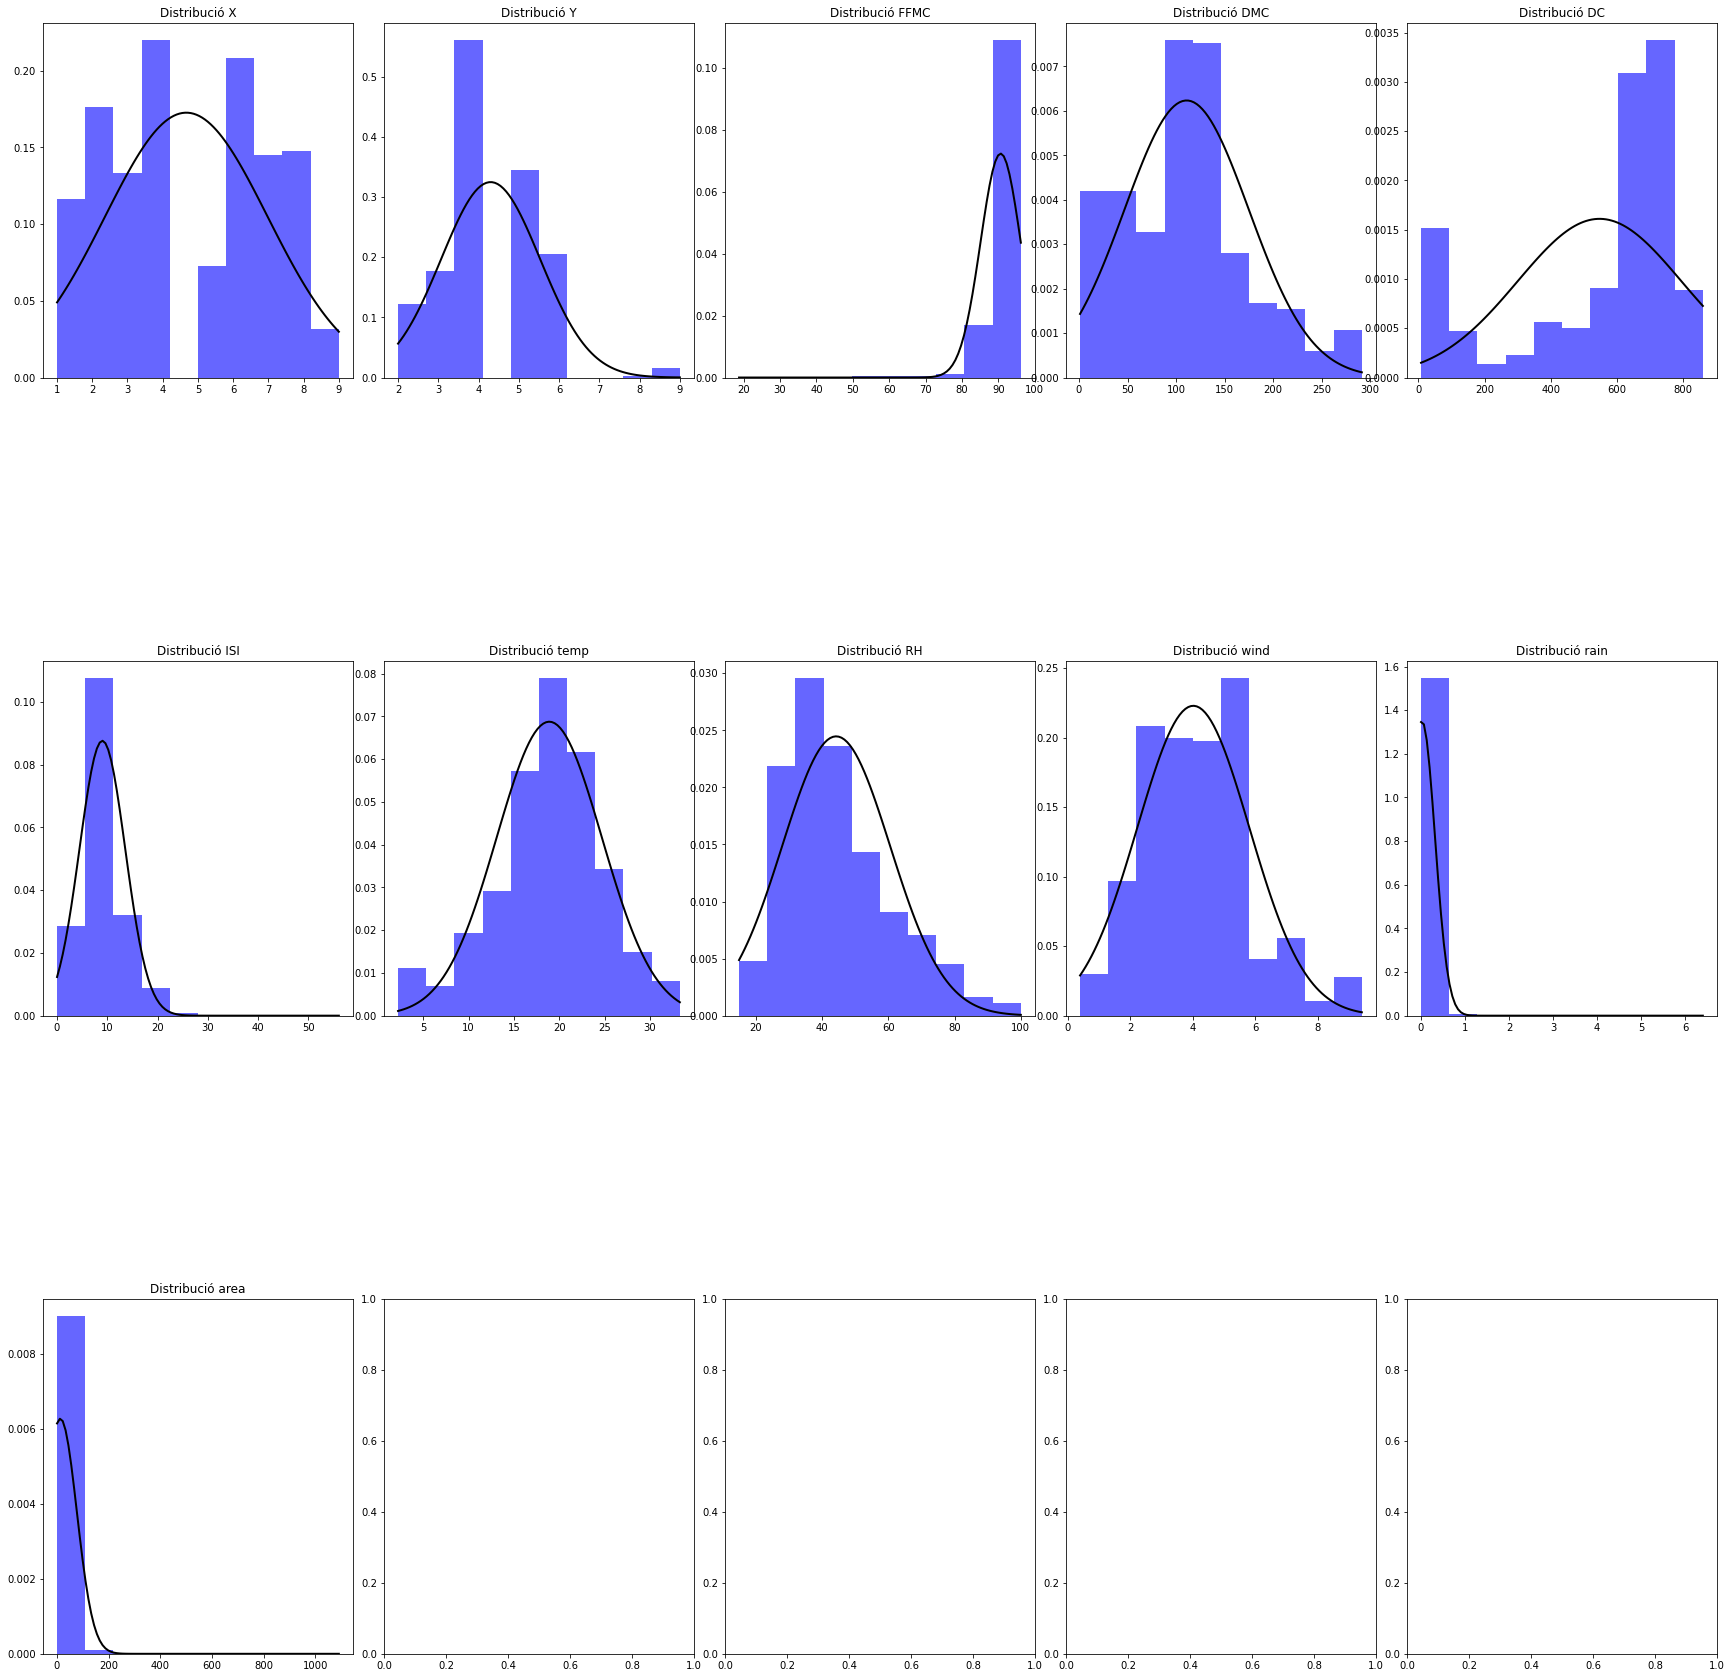

In [19]:
dfg=dfo.copy()
fig, ax = plt.subplots(3,5,figsize=(30,30))
i=0
j=0
dfg.pop('month')
dfg.pop('day')

for col in dfg.columns:
    dc = dfg[col]
    
    mu, std = stats.norm.fit(dc) 
    x = np.linspace(min(dc), max(dc), 100)
    p = stats.norm.pdf(x, mu, std)
    
    ax[i,j].plot(x, p, 'k', linewidth=2)
    ax[i,j].hist(dc, density=True, alpha=0.6, color='b')
    ax[i,j].set_title("Distribució " +col)
    
    j = j+1
    if j == 5:
        j = 0
        i = i+1

plt.subplots_adjust(hspace=0.8, wspace = 0.10)
plt.show(-1)

Després de fer un histograma de cada parametre podem veure com les dades els atributs següents segueixen tots una distribucio normal o gaussiana. La temperatura i l'ISI molt segurament segueixen una gaussiana. I l'humitat relativa (RH) podria ser que també, però està desplaçada.

### 1.3 Atribut objectiu

Creiem que l'atribut objectiu es l'area ja que es l'atribut que mes interessant a analitzar segons les condicions mesurades que ens dona el dataset i així poder predir sota unes noves condicions l'abast d'un incendi. Tot i així a primera vista creiem que una regressió lineal simple no seria útil per fer aquesta anàlisi.

# Apartat(B): Primeres regressions

A continuació s'exposaran diferents mètodes de regressió pel nostre dataframe per veure quins ens donen millors prediccions.

## Escala logaritmica de l'area

Transformem l'area seguint $ln(x+1)$ per fer-la una escala logaritmica com la de richter, ja que vam trobar el paper original del dataset i ho recomenaven per un processament millor i mes fàcil de l'area a l'hora de fer regressió.

<AxesSubplot:title={'center':'Dades sense normalitzar de area'}, xlabel='Valor', ylabel='Frequencia'>

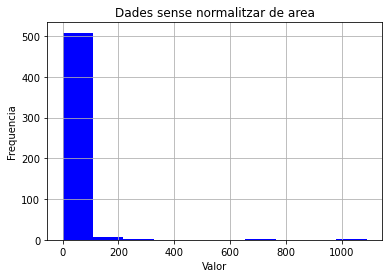

In [20]:
plt.xlabel('Valor')
plt.ylabel('Frequencia')
plt.title('Dades sense normalitzar de area')
df.area.hist(color="blue")

A més a més també provarem de afegir una columna mes similar a la *Damage Category* d'abans per poder fer una regressió logística amb la gravetat dels incendis

In [21]:
def area_cat(area):
    if area <= 24.6:
        return 0
    else:
        return 1

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0


<AxesSubplot:title={'center':'ln(area+1)'}, xlabel='Valor', ylabel='Frequencia'>

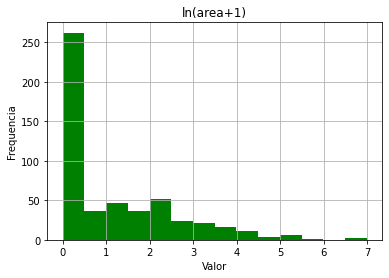

In [22]:
df['area'] = df['area'].apply(lambda x: np.log(x+1))
plt.xlabel('Valor')
plt.ylabel('Frequencia')
plt.title('ln(area+1)')
df.area.hist(color="green", bins='auto')

## Regressió Lineal

En aquest apartat provarem diferents maneres de fer una regressió lineal i els seus resultats pertinents

### Bàsica

In [23]:
idx = df.sample(frac=0.7).index

train_df = df[df.index.isin(idx)]
test_df = df[~df.index.isin(idx)]


train_df_x = train_df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
train_df_y = train_df['area']

test_df_x = test_df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
test_df_y = test_df['area']

print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")

Train: (362, 14)
Test: (155, 14)


In [24]:
var_list = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
suma = []
for i in range (len(var_list)):
    suma.append(metrics.mean_squared_error(train_df_y, train_df_x[var_list[i]]))
print(suma)

[8018.646777161003, 16322.25203535416, 349520.66235609277, 87.24342122792287, 350.4778497536598, 2129.166544577629, 13.896287036633508, 3.2017087192942046]


In [25]:
def standarize1(x, mean=None, std=None):
    if mean is None:
        mean = x.mean(0)
    if std is None:
        std = x.std(0)
    
    return (x - mean[None, :]) / std[None, :], mean, std

In [26]:
train_df_x_norm = train_df_x.values
test_df_x_norm = test_df_x.values
train_df_x_norm, mean, std = standarize1(train_df_x.values)
test_df_x_norm, _, _ = standarize1(test_df_x.values, mean, std)

FFMC - MSE: 1.951; R2: 0.001; MAE: 1.113
DMC - MSE: 1.938; R2: 0.008; MAE: 1.107
DC - MSE: 1.938; R2: 0.008; MAE: 1.107
ISI - MSE: 1.953; R2: -0.000; MAE: 1.109
temp - MSE: 1.944; R2: 0.005; MAE: 1.112
RH - MSE: 1.943; R2: 0.005; MAE: 1.110
wind - MSE: 1.941; R2: 0.006; MAE: 1.103
rain - MSE: 1.956; R2: -0.001; MAE: 1.111


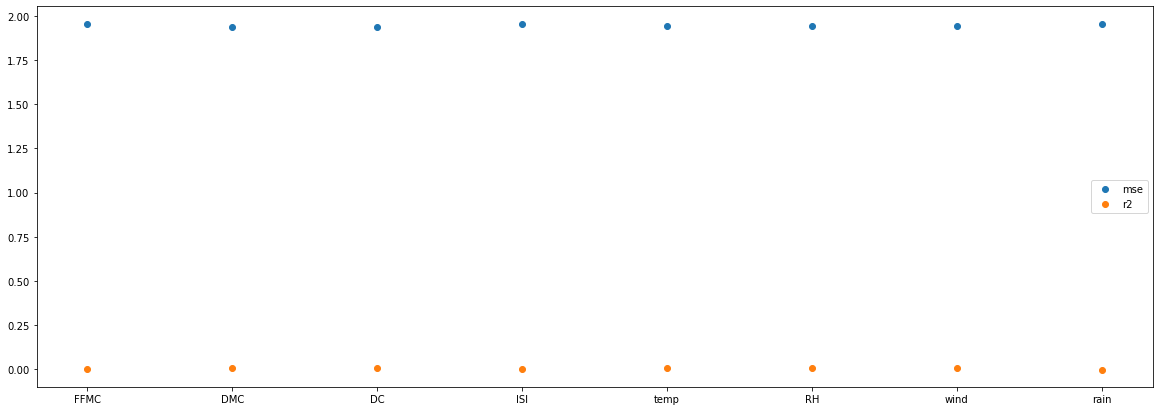

In [27]:
linear_model = LinearRegression()    

features = train_df_x.columns
train_y = train_df_y
test_y = test_df_y

mses, r2s = [], []
features = features.tolist()

mses, r2s = [], []
for idx, feature in enumerate(features):
    regr=LinearRegression().fit(train_df_x_norm[:, idx, None], train_df_y)
    preds = regr.predict(test_df_x_norm[:, idx, None])
       
    mse = metrics.mean_squared_error(test_df_y, preds)
    mae = metrics.mean_absolute_error(test_df_y, preds)
    mses.append(mse)
    
    r2 = metrics.r2_score(test_y, preds)
    r2s.append(r2)

    print(f"{feature} - MSE: {mse:.3f}; R2: {r2:.3f}; MAE: {mae:.3f}")

mses = np.array(mses)
r2s = np.array(r2s)
plt.figure(figsize=(20,7)) 
plt.scatter(features, mses, label='mse')
plt.scatter(features, r2s, label='r2')
plt.legend()
plt.show()

Com podem observar tots els atributs individualment obtenen un $R^2$ score molt baix i un MSE que ronda el 1,8. Haurem de recurrir a altres metodes per poder fer la regressió

### PCA

PCA_1 - MSE: 1.939; R2: 0.007
PCA_2 - MSE: 1.941; R2: 0.006
PCA_3 - MSE: 1.942; R2: 0.006
PCA_4 - MSE: 1.945; R2: 0.004
PCA_5 - MSE: 1.899; R2: 0.028
PCA_6 - MSE: 1.894; R2: 0.030
PCA_7 - MSE: 1.894; R2: 0.030
PCA_8 - MSE: 1.912; R2: 0.021


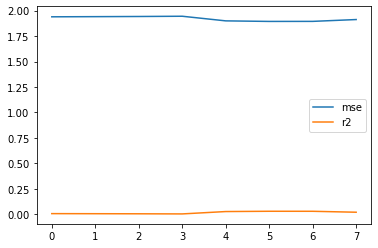

In [28]:
mses, r2s = [], []
for i in range(1, 9):
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(train_df_x_norm)
    x_test = pca.transform(test_df_x_norm)

    linear_model = LinearRegression()
    linear_model.fit(x_train, train_df_y)
    preds = linear_model.predict(x_test)

    mse = metrics.mean_squared_error(test_df_y, preds)
    r2 = metrics.r2_score(test_df_y, preds)
    print(f"PCA_{i} - MSE: {mse:.3f}; R2: {r2:.3f}")
    
    mses.append(mse)
    r2s.append(r2)
    
plt.plot(mses, label='mse')
plt.plot(r2s, label='r2')
plt.legend()
plt.show()

Despres de realitzar el PCA per trobar alguna mena de millora a la nostra regressió podem observar que el canvi que hi ha es inapreciable i que el $R^2$ i el MSE segueixen rondant molt propers als valors abans vists.

### Extraient els zeros

Provem si podem dividir la regressió en dos parts. La primera part una logística per predir si seria un zero o un incendi més important, i la segona, en la classe d'incendis importants predir l'area

In [29]:
def area_cat(area):
    if area == 0:
        return 0
    else:
        return 1

dfc=dfo.copy()
dfc['damage_category'] = dfc['area'].apply(area_cat)
dfc['area'] = dfc['area'].apply(lambda x: np.log(x+1))
dfc.pop('month')
dfc.pop('day')
#dfc=dfc.replace(dfc['month'].unique(),[3,10,8,9,4,6,7,2,1,12,5,11]).replace(dfc['day'].unique(),[5,2,6,7,1,3,4])
area=dfc.pop('area')
y=dfc.pop('damage_category')
x=dfc

Aquest seria l'histograma de l'area sense els zeros. Llavors ara procedim a fer les dues regressions

In [30]:
y

0      0
1      0
2      0
3      0
4      0
      ..
512    1
513    1
514    1
515    0
516    0
Name: damage_category, Length: 517, dtype: int64

In [31]:
x

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


In [32]:
x.shape

(517, 10)

In [33]:
x,mean,std=standarize1(x)

C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\1727565841.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return (x - mean[None, :]) / std[None, :], mean, std


In [34]:
idx = df.sample(frac=0.7).index
x_tr = x[x.index.isin(idx)]
x_te = x[~x.index.isin(idx)]
y_tr = y[y.index.isin(idx)]
y_te = y[~y.index.isin(idx)]

In [35]:
LG=LogisticRegression(C=10)
LG.fit(x_tr,y_tr)
y_pred=LG.predict(x_te)
metrics.confusion_matrix(y_te,y_pred)

array([[25, 50],
       [28, 52]], dtype=int64)

Veiem que la matriu de confusio ens dona molts errors, igualment provem amb el cross validation

In [36]:
scores=cross_val_score(LG,x_tr,y_tr,cv=7)
print("Scores: ",scores)

Scores:  [0.51923077 0.48076923 0.57692308 0.44230769 0.38461538 0.58823529
 0.43137255]


La classificació no es útil. Igualment provarem a fer la regressió lineal sense els zeros i despres una pca, per veure si al extreure'ls i no tenint-los en compte millora la regressió de la resta de casos.

In [37]:
dfc=dfo.copy()
dfc.pop('month')
dfc.pop('day')
dfc=dfc[dfc['area']>0.0]
dfc['area'] = dfc['area'].apply(lambda x: np.log(x+1))

In [38]:
idx = dfc.sample(frac=0.7).index

train_df = dfc[dfc.index.isin(idx)]
test_df = dfc[~dfc.index.isin(idx)]


train_df_x = train_df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
train_df_y = train_df['area']

test_df_x = test_df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
test_df_y = test_df['area']

print(dfc.columns)
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')
Train: (189, 11)
Test: (81, 11)


In [39]:
var_list = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
suma = []
for i in range (len(var_list)):
    suma.append(metrics.mean_squared_error(train_df_y, train_df_x[var_list[i]]))
print(suma)

[7889.5506385697145, 16802.939408403658, 380812.2898645591, 69.99199450632707, 338.4210267688379, 1970.9077620718908, 8.916533638537262, 6.536362224810757]


In [40]:
train_df_x_norm= train_df_x.values
test_df_x_norm = test_df_x.values

train_df_x_norm, mean, std = standarize1(train_df_x.values)
test_df_x_norm, _, _ = standarize1(test_df_x.values, mean, std)

FFMC - MSE: 1.370; R2: -0.047; MAE: 0.979
DMC - MSE: 1.380; R2: -0.055; MAE: 0.990
DC - MSE: 1.380; R2: -0.055; MAE: 0.988
ISI - MSE: 1.447; R2: -0.106; MAE: 1.006
temp - MSE: 1.360; R2: -0.039; MAE: 0.978
RH - MSE: 1.354; R2: -0.035; MAE: 0.973
wind - MSE: 1.366; R2: -0.044; MAE: 0.982
rain - MSE: 1.360; R2: -0.039; MAE: 0.979


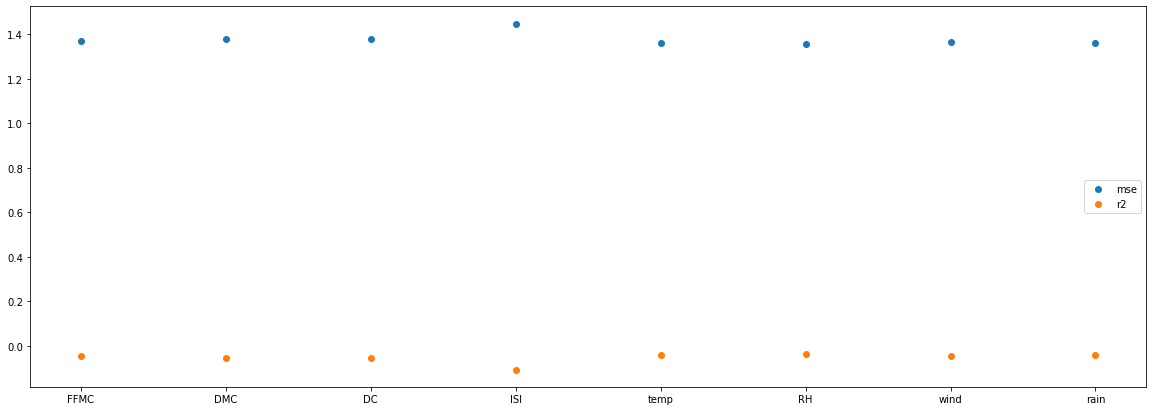

In [41]:
linear_model = LinearRegression()    

features = train_df_x.columns
train_y = train_df_y
test_y = test_df_y

mses, r2s = [], []
features = features.tolist()

mses, r2s = [], []
for idx, feature in enumerate(features):
    regr=LinearRegression().fit(train_df_x_norm[:, idx, None], train_df_y)
    preds = regr.predict(test_df_x_norm[:, idx, None])
       
    mse = metrics.mean_squared_error(test_df_y, preds)
    mae = metrics.mean_absolute_error(test_df_y, preds)
    mses.append(mse)
    
    r2 = metrics.r2_score(test_y, preds)
    r2s.append(r2)

    print(f"{feature} - MSE: {mse:.3f}; R2: {r2:.3f}; MAE: {mae:.3f}")

mses = np.array(mses)
r2s = np.array(r2s)
plt.figure(figsize=(20,7)) 
plt.scatter(features, mses, label='mse')
plt.scatter(features, r2s, label='r2')
plt.legend()
plt.show()

PCA_1 - MSE: 1.359; R2: -0.039
PCA_2 - MSE: 1.422; R2: -0.087
PCA_3 - MSE: 1.464; R2: -0.119
PCA_4 - MSE: 1.466; R2: -0.120
PCA_5 - MSE: 1.457; R2: -0.114
PCA_6 - MSE: 1.501; R2: -0.147
PCA_7 - MSE: 1.486; R2: -0.135
PCA_8 - MSE: 1.487; R2: -0.137


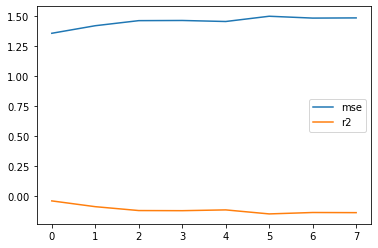

In [42]:
mses, r2s = [], []
for i in range(1, 9):
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(train_df_x_norm)
    x_test = pca.transform(test_df_x_norm)

    linear_model = LinearRegression()
    linear_model.fit(x_train, train_df_y)
    preds = linear_model.predict(x_test)

    mse = metrics.mean_squared_error(test_df_y, preds)
    r2 = metrics.r2_score(test_df_y, preds)
    print(f"PCA_{i} - MSE: {mse:.3f}; R2: {r2:.3f}")
    
    mses.append(mse)
    r2s.append(r2)
    
plt.plot(mses, label='mse')
plt.plot(r2s, label='r2')
plt.legend()
plt.show()

El MSE es redueix unes quantes dècimes i l'$R^2$ score es mante més o menys, es un resultat que potser combinat amb alguna tècnica més pot donar resultats satisfactoris. Tot i que s'ha de tenir en compte que s'estan ignorant més de dos-cents incendis.

## Regressió polinomica

### Básica

In [43]:
dfp=dfo.copy()
#dfp=dfp.replace(dfp['month'].unique(),[3,10,8,9,4,6,7,2,1,12,5,11]).replace(dfp['day'].unique(),[5,2,6,7,1,3,4])
dfp.pop('day')
dfp.pop('month')
dfp.pop('X')
dfp.pop('Y')
dfp=dfp[dfp['area']>0.0]
dfp['area'] = dfp['area'].apply(lambda x: np.log(x+1))
y= np.array(dfp.pop('area'))
dfp.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889
std,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392
min,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000
25%,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000
50%,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000
75%,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000
max,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000


In [44]:
polynomials=[]
for i, column in enumerate(dfp):
  X= np.array(dfp[column]).reshape(-1,1)
  X,mean,std=standarize1(X)
  X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=22)
  ply_deg=(float('-inf'),float('-inf'))
  for j in range(2,30):
    polyreg=make_pipeline(PolynomialFeatures(j),LinearRegression())
    model = polyreg.fit(X_tr,y_tr)
    score=model.score(X_te,y_te)
    if(score>ply_deg[0]):
      ply_deg=(score,j)
  polynomials.append((ply_deg,column))
for i in range(0,len(polynomials)):
  print("Var:",polynomials[i][1],"  Degree: ",polynomials[i][0][1],"  Score: ",polynomials[i][0][0])

Var: FFMC   Degree:  3   Score:  -0.06229160892105079
Var: DMC   Degree:  3   Score:  0.0021790802250887253
Var: DC   Degree:  3   Score:  -0.008095299828996705
Var: ISI   Degree:  6   Score:  -0.01648359710942149
Var: temp   Degree:  12   Score:  0.008516451680877779
Var: RH   Degree:  2   Score:  -0.01675294312548714
Var: wind   Degree:  2   Score:  -0.0016293262757878235
Var: rain   Degree:  22   Score:  -0.0076226389198508215


Veiem que els resultats amb les variables no ens donen una bona score, llavors no es una regressió massa útil

## Regressió multivariada

### Básica

C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\1120116416.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


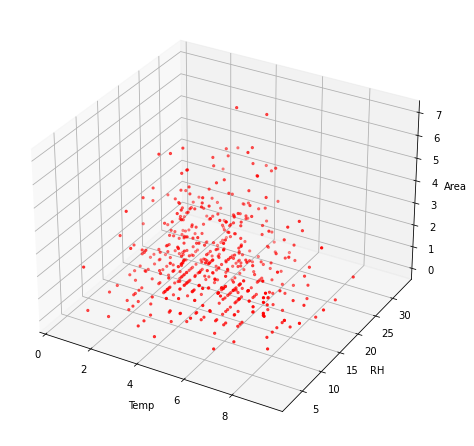

In [45]:
dfm=dfo.copy()
dfm=dfm[dfm['area']>0.0]
dfm['area'] = dfm['area'].apply(lambda x: np.log(x+1))

fig = plt.figure(figsize=(8, 6))      
ax = Axes3D(fig)

x1 = df["wind"]                             
x2 = df["temp"]                             
y = df["area"]                               

ax.scatter(x1, x2, y, marker='.', c='r')
ax.set_xlabel('Temp')        
ax.set_ylabel('RH')       
ax.set_zlabel('Area');

In [46]:
mod = smf.ols('y ~ x1 + x2', data=df).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.455
Date:                Mon, 10 Oct 2022   Prob (F-statistic):             0.0869
Time:                        17:05:23   Log-Likelihood:                -904.01
No. Observations:                 517   AIC:                             1814.
Df Residuals:                     514   BIC:                             1827.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5199      0.281      1.850      0.0

In [47]:
mod.params

Intercept    0.519907
x1           0.065115
x2           0.017445
dtype: float64

In [48]:
mod.mse_resid

1.9446575445975374

In [49]:
max(df['DMC'])

291.3

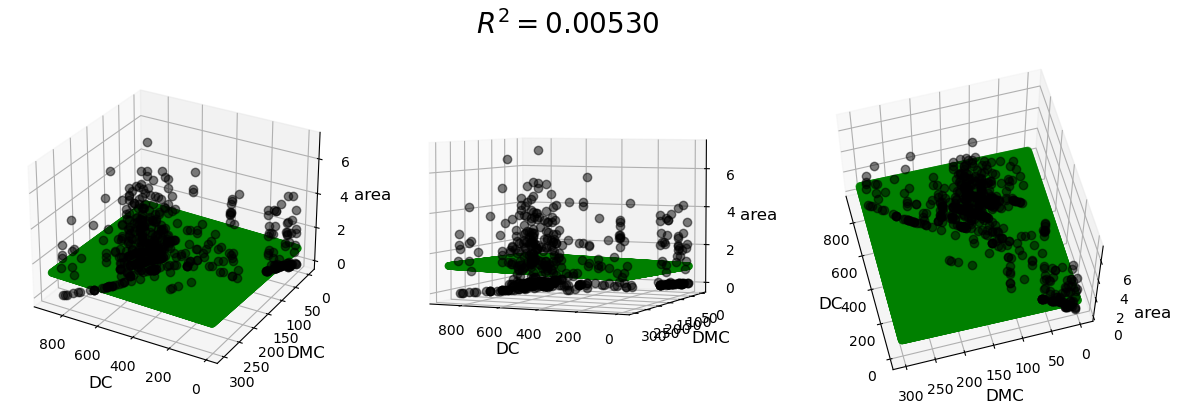

In [50]:
X = df[['DC','DMC']].values.reshape(-1,2)
Y = df['area']

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(6, 900, 270)   # range of porosity values
y_pred = np.linspace(0, 300, 270)  # range of brittleness values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

ols = LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)

r2 = model.score(X, Y)

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='green')
    ax.set_xlabel('DC', fontsize=12)
    ax.set_ylabel('DMC', fontsize=12)
    ax.set_zlabel('area', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')


ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.5f$' % r2, fontsize=20)

fig.tight_layout()

Veiem que l'$R^2$ score no es alta, així que seguirem provant més maneres de fer regressions

### OneHot

Hem aplicat l'One-hot encoding als mesos i als dies per veure si així millora la regressió ja que ara aquests ara si serán mes utils per la regressió.

In [51]:
def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr
    
def standarize2(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

In [52]:
dfh=dfo.copy()

Primer farem els mesos

In [53]:
dfh = dfh[[ 'month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'rain', 'area']]

enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(dfh[['month']]).toarray())
df_OneHot = dfh.join(enc_df)
df_OneHot.pop('month')
df_OneHot= df_OneHot[[ 'FFMC','DMC','DC','ISI','temp','RH','wind','rain','area',0,1,2,3,4,5,6,7,8,9,10,11]]
df_OneHot = df_OneHot.rename(columns={i: f"{i}" for i in range(0,12)})
df_OneHot

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,0,...,2,3,4,5,6,7,8,9,10,11
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0,...,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,...,0,0,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,...,0,0,0,0,0,0,0,0,1,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0,...,0,0,0,0,0,1,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,0,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,...,0,0,0,0,0,0,0,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,0


Transformem l'area i treiem els zeros

In [54]:
df_OneHot["area"]=df_OneHot["area"].apply(lambda x: np.log(x+1))
df_OneHot=df_OneHot[df_OneHot["area"]>0.00]

df_OneHot.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,0,...,2,3,4,5,6,7,8,9,10,11
138,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.307485,0,...,0,0,0,1,0,0,0,0,0,0
139,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.357674,0,...,0,0,0,0,0,0,0,0,0,1
140,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.385262,0,...,0,0,0,0,0,0,0,0,0,1
141,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.438255,0,...,0,0,0,0,0,0,0,0,0,0
142,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.476234,0,...,0,0,0,0,0,0,0,0,0,0


Estandaritzem les x

In [55]:
x1=df_OneHot[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
x2=df_OneHot[['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']]
y=df_OneHot['area']
x_t = standarize2(x1)
x_t = pd.concat([x_t, x2], axis=1)
x_t

C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\2497265513.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_t = x_train - mean[None, :]
C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\2497265513.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_t /= std[None, :]


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,0,1,2,3,4,5,6,7,8,9,10,11
138,-1.411175,-1.074794,-1.119513,-1.272388,-0.212173,-0.114942,-0.749752,-0.072514,0,0,0,0,0,1,0,0,0,0,0,0
139,-0.009187,0.239409,0.529317,-0.524922,0.386586,-0.380193,-1.015064,-0.072514,0,0,0,0,0,0,0,0,0,0,0,1
140,-0.036148,0.190854,0.502793,-0.524922,0.418952,-0.313880,-1.227314,-0.072514,0,0,0,0,0,0,0,0,0,0,0,1
141,1.204072,-0.239660,-0.250312,0.970008,0.645509,-0.844382,0.205371,-0.072514,0,1,0,0,0,0,0,0,0,0,0,0
142,-0.251839,-0.108564,-0.178567,0.801226,0.305673,0.481873,2.540117,-0.072514,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,-0.009187,0.844719,0.790208,-0.500811,0.289490,1.808127,1.850306,3.441613,0,1,0,0,0,0,0,0,0,0,0,0
510,-0.009187,0.844719,0.790208,-0.500811,-0.179808,1.211313,0.682933,-0.072514,0,1,0,0,0,0,0,0,0,0,0,0
512,-2.543549,-0.938842,0.411916,-1.754623,1.373730,-0.778069,-0.749752,-0.072514,0,1,0,0,0,0,0,0,0,0,0,0
513,-2.543549,-0.938842,0.411916,-1.754623,0.418952,1.808127,0.895183,-0.072514,0,1,0,0,0,0,0,0,0,0,0,0


In [56]:
model = sm.OLS(y,x_t).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.631
Date:                Mon, 10 Oct 2022   Prob (F-statistic):             0.0570
Time:                        17:05:31   Log-Likelihood:                -430.36
No. Observations:                 270   AIC:                             896.7
Df Residuals:                     252   BIC:                             961.5
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0165      0.130      0.127      0.8

In [57]:
regr = regression(x_t, y) 
predicted = regr.predict(x_t)

# Mostrem l'error (MSE i R2 i MAE)
MSE = metrics.mean_squared_error(y, predicted)
r2 = metrics.r2_score(y, predicted)
MAE = metrics.mean_absolute_error(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)
print("Mean absolute error: ", MAE)

Mean squeared error:  1.4190250040837422
R2 score:  0.0991184060379634
Mean absolute error:  0.9353861578964056


Obtenim que amb un One-hot dels mesos obtenim la millor $R^2$ score i el millor MSE també

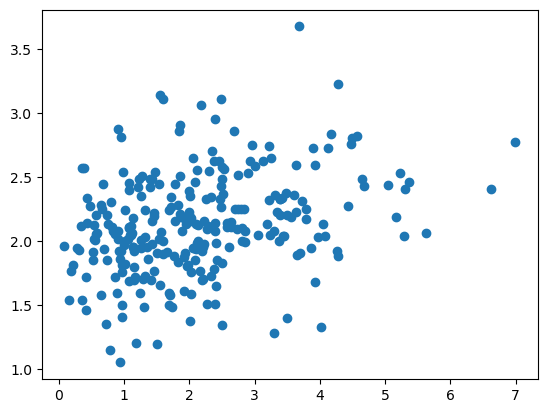

In [58]:
plt.scatter(y.values,predicted)

Ara provem amb el One-hot dels dies

In [59]:
dfh=dfo.copy()
dfh = dfh[[  'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'rain', 'area']]

enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(dfh[['day']]).toarray())
df_OneHot = dfh.join(enc_df)
df_OneHot.pop('day')

df_OneHot = df_OneHot.rename(columns={i: f"{i}" for i in range(0,7)})
df_OneHot

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,0,1,2,3,4,5,6
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,0,0,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,0,1,0,0,0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,0,0,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,0,0,1,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,0,0,1,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,0,0,1,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,0,1,0,0,0,0


In [60]:
df_OneHot["area"]=df_OneHot["area"].apply(lambda x: np.log(x+1))
df_OneHot=df_OneHot[df_OneHot["area"]>0.00]

df_OneHot.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,0,1,2,3,4,5,6
138,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.307485,0,0,0,0,0,1,0
139,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.357674,0,0,0,0,0,1,0
140,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.385262,0,1,0,0,0,0,0
141,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.438255,0,0,0,0,0,0,1
142,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.476234,1,0,0,0,0,0,0


In [61]:
data = df_OneHot.values

y=df_OneHot[['area']]
x= df_OneHot[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', '0','1', '2', '3', '4', '5', '6']]

df_OneHot.columns

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', '0',
       '1', '2', '3', '4', '5', '6'],
      dtype='object')

In [62]:
x1=x[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
x2=x[[ '0','1', '2', '3', '4', '5', '6']]

x_t = standarize2(x1)
x_t = pd.concat([x_t, x2], axis=1)
x_t

C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\2497265513.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_t = x_train - mean[None, :]
C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\2497265513.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_t /= std[None, :]


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,0,1,2,3,4,5,6
138,-1.411175,-1.074794,-1.119513,-1.272388,-0.212173,-0.114942,-0.749752,-0.072514,0,0,0,0,0,1,0
139,-0.009187,0.239409,0.529317,-0.524922,0.386586,-0.380193,-1.015064,-0.072514,0,0,0,0,0,1,0
140,-0.036148,0.190854,0.502793,-0.524922,0.418952,-0.313880,-1.227314,-0.072514,0,1,0,0,0,0,0
141,1.204072,-0.239660,-0.250312,0.970008,0.645509,-0.844382,0.205371,-0.072514,0,0,0,0,0,0,1
142,-0.251839,-0.108564,-0.178567,0.801226,0.305673,0.481873,2.540117,-0.072514,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,-0.009187,0.844719,0.790208,-0.500811,0.289490,1.808127,1.850306,3.441613,1,0,0,0,0,0,0
510,-0.009187,0.844719,0.790208,-0.500811,-0.179808,1.211313,0.682933,-0.072514,1,0,0,0,0,0,0
512,-2.543549,-0.938842,0.411916,-1.754623,1.373730,-0.778069,-0.749752,-0.072514,0,0,0,1,0,0,0
513,-2.543549,-0.938842,0.411916,-1.754623,0.418952,1.808127,0.895183,-0.072514,0,0,0,1,0,0,0


In [63]:
model = sm.OLS(y,x_t).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.026
Date:                Mon, 10 Oct 2022   Prob (F-statistic):              0.428
Time:                        17:05:31   Log-Likelihood:                -437.05
No. Observations:                 270   AIC:                             904.1
Df Residuals:                     255   BIC:                             958.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0302      0.128      0.236      0.8

In [64]:
regr = regression(x_t, y) 
predicted = regr.predict(x_t)

# Mostrem l'error (MSE i R2 i MAE)
MSE = metrics.mean_squared_error(y, predicted)
r2 = metrics.r2_score(y, predicted)
MAE = metrics.mean_absolute_error(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)
print("Mean absolute error: ", MAE)

Mean squeared error:  1.4911768883617382
R2 score:  0.053312092316454396
Mean absolute error:  0.9654539403049832


Obtenim uns resultats millors que els base, però no es millor que el One-hot dels mesos.

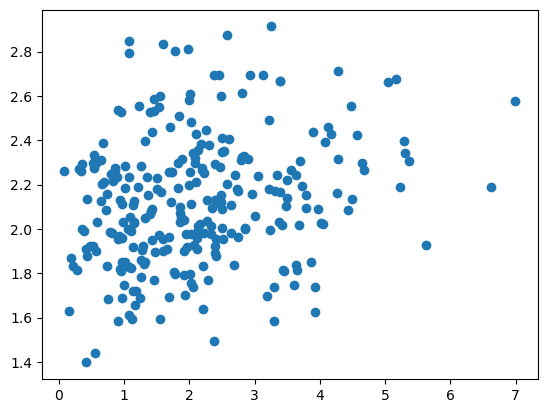

In [65]:
plt.scatter(y.values,predicted)

Ara provarem de fer el One-hot amb els dies i els mesos

In [66]:
dfh=dfo.copy()

In [67]:
dfh = dfh[[ 'month',  'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'rain', 'area']]

enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(dfh[['day']]).toarray())
df_OneHot = dfh.join(enc_df)
df_OneHot.pop('day')

df_OneHot = df_OneHot.rename(columns={ i: 'Day {}'.format(i) for i in range(0,7)})
df_OneHot.head()

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Day 0,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6
0,mar,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0
1,oct,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0
2,oct,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0
3,mar,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0
4,mar,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0


In [68]:
enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(df_OneHot[['month']]).toarray())
df_OneHot = df_OneHot.join(enc_df)
df_OneHot.pop('month')

df_OneHot = df_OneHot.rename(columns={ i: 'Month {}'.format(i) for i in range(0,12)})
df_OneHot.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Day 0,...,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,...,0,0,0,0,0,1,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0


In [69]:
df_OneHot["area"]=df_OneHot["area"].apply(lambda x: np.log(x+1))
df_OneHot=df_OneHot[df_OneHot["area"]>0.00]

df_OneHot.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Day 0,...,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
138,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.307485,0,...,0,0,0,1,0,0,0,0,0,0
139,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.357674,0,...,0,0,0,0,0,0,0,0,0,1
140,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.385262,0,...,0,0,0,0,0,0,0,0,0,1
141,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.438255,0,...,0,0,0,0,0,0,0,0,0,0
142,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.476234,1,...,0,0,0,0,0,0,0,0,0,0


In [70]:
data = df_OneHot.values

y=df_OneHot[['area']]
x= df_OneHot[['FFMC', 'DMC', 'DC', 'ISI','temp', 'RH', 'wind', 'rain', 'Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5','Day 6','Month 0', 'Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5','Month 6', 'Month 7', 'Month 8', 'Month 9', 'Month 10', 'Month 11']]

In [71]:
x1=x[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
x2=x[[  'Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5','Day 6','Month 0', 'Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5','Month 6', 'Month 7', 'Month 8', 'Month 9', 'Month 10', 'Month 11']]

x_t = standarize2(x1)
x_t = pd.concat([x_t, x2], axis=1)
x_t

C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\2497265513.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_t = x_train - mean[None, :]
C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\2497265513.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_t /= std[None, :]


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,Day 0,Day 1,...,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
138,-1.411175,-1.074794,-1.119513,-1.272388,-0.212173,-0.114942,-0.749752,-0.072514,0,0,...,0,0,0,1,0,0,0,0,0,0
139,-0.009187,0.239409,0.529317,-0.524922,0.386586,-0.380193,-1.015064,-0.072514,0,0,...,0,0,0,0,0,0,0,0,0,1
140,-0.036148,0.190854,0.502793,-0.524922,0.418952,-0.313880,-1.227314,-0.072514,0,1,...,0,0,0,0,0,0,0,0,0,1
141,1.204072,-0.239660,-0.250312,0.970008,0.645509,-0.844382,0.205371,-0.072514,0,0,...,0,0,0,0,0,0,0,0,0,0
142,-0.251839,-0.108564,-0.178567,0.801226,0.305673,0.481873,2.540117,-0.072514,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,-0.009187,0.844719,0.790208,-0.500811,0.289490,1.808127,1.850306,3.441613,1,0,...,0,0,0,0,0,0,0,0,0,0
510,-0.009187,0.844719,0.790208,-0.500811,-0.179808,1.211313,0.682933,-0.072514,1,0,...,0,0,0,0,0,0,0,0,0,0
512,-2.543549,-0.938842,0.411916,-1.754623,1.373730,-0.778069,-0.749752,-0.072514,0,0,...,0,0,0,0,0,0,0,0,0,0
513,-2.543549,-0.938842,0.411916,-1.754623,0.418952,1.808127,0.895183,-0.072514,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
model = sm.OLS(y,x_t).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.474
Date:                Mon, 10 Oct 2022   Prob (F-statistic):             0.0795
Time:                        17:05:32   Log-Likelihood:                -427.02
No. Observations:                 270   AIC:                             902.0
Df Residuals:                     246   BIC:                             988.4
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0093      0.132      0.071      0.9

In [73]:
regr = regression(x_t, y) 
predicted = regr.predict(x_t)

# Mostrem l'error (MSE i R2 i MAE)
MSE = metrics.mean_squared_error(y, predicted)
r2 = metrics.r2_score(y, predicted)
MAE = metrics.mean_absolute_error(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)
print("Mean absolute error: ", MAE)

Mean squeared error:  1.3843533522502058
R2 score:  0.12113003576908388
Mean absolute error:  0.9155113047940682


In [74]:
# creates a pca model
pca_best = PCA()
x_train = pca_best.fit_transform(x_t)
x_test = pca_best.transform(x_t)

linear_model = LinearRegression()
linear_model.fit(x_train, y)
preds = linear_model.predict(x_test)

mse_pca = metrics.mean_squared_error(y, preds)
r2_pca = metrics.r2_score(y, preds)

#information of the best pca 
print(f"Best PCA obtained with {len(pca_best.singular_values_)} components")
print("Test R2:",r2_pca)
print("Test MSE:",mse_pca)

Best PCA obtained with 27 components
Test R2: 0.12113003576908388
Test MSE: 1.3843533522502058


Amb els dos One-hot els resultats milloren per sobre dels individuals i obtenim el major $R^2$ score que tenim.

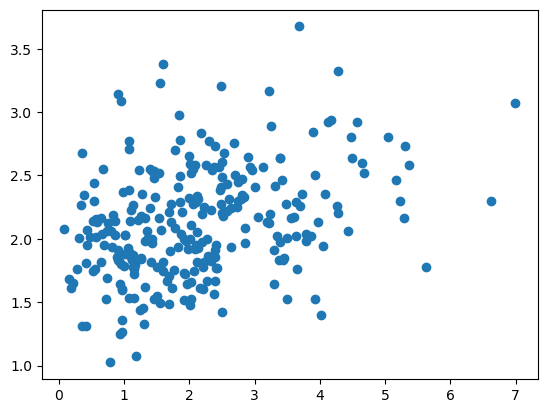

In [75]:
plt.scatter(y.values,predicted)

### Totes les variables

In [76]:
dfHo = dfo.copy()
print(dfHo.columns)
print(len(dfHo.columns))

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')
13


#### OneHot per els X

In [77]:
enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(dfHo[['X']]).toarray())
dfHo = dfHo.join(enc_df)
dfHo.pop('X')
df_OneHot = dfHo.rename(columns={ i: 'X_{}'.format(i) for i in range(0,9)})

print(df_OneHot.columns)
print(len(df_OneHot.columns))

Index(['Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8'],
      dtype='object')
21


#### OneHot per els Y

In [78]:
enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(df_OneHot[['Y']]).toarray())
df_OneHot = df_OneHot.join(enc_df)
df_OneHot.pop('Y')
df_OneHot = df_OneHot.rename(columns={ i: 'Y_{}'.format(i) for i in range(0,7)})

print(df_OneHot.columns)
print(len(df_OneHot.columns))

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'Y_0', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6'],
      dtype='object')
27


#### OneHot per els dies

In [79]:
enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(df_OneHot[['day']]).toarray())
df_OneHot = df_OneHot.join(enc_df)
df_OneHot.pop('day')
df_OneHot = df_OneHot.rename(columns={ i: 'Day {}'.format(i) for i in range(0,7)})

print(df_OneHot.columns)
print(len(df_OneHot.columns))

Index(['month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8',
       'Y_0', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Day 0', 'Day 1',
       'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6'],
      dtype='object')
33


#### OneHot per els mesos

In [80]:
enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(df_OneHot[['month']]).toarray())
df_OneHot = df_OneHot.join(enc_df)
df_OneHot.pop('month')
df_OneHot = df_OneHot.rename(columns={ i: 'Month {}'.format(i) for i in range(0,12)})

print(df_OneHot.columns)
print(len(df_OneHot.columns))

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'X_0',
       'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'Y_0', 'Y_1',
       'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Day 0', 'Day 1', 'Day 2', 'Day 3',
       'Day 4', 'Day 5', 'Day 6', 'Month 0', 'Month 1', 'Month 2', 'Month 3',
       'Month 4', 'Month 5', 'Month 6', 'Month 7', 'Month 8', 'Month 9',
       'Month 10', 'Month 11'],
      dtype='object')
44


#### Apliquem una transormació a l'area


In [81]:
df_OneHot["area"]=df_OneHot["area"].apply(lambda x: np.log(x+1))
df_OneHot=df_OneHot[df_OneHot["area"]>0.00]
df_OneHot.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,X_0,...,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
138,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.307485,0,...,0,0,0,1,0,0,0,0,0,0
139,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.357674,1,...,0,0,0,0,0,0,0,0,0,1
140,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.385262,0,...,0,0,0,0,0,0,0,0,0,1
141,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.438255,1,...,0,0,0,0,0,0,0,0,0,0
142,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.476234,0,...,0,0,0,0,0,0,0,0,0,0


#### Fem la estandarització


In [82]:
y=df_OneHot[['area']]

x1=df_OneHot[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
x2=df_OneHot[[ 'X_0','X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'Y_0', 'Y_1','Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6','Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5','Day 6','Month 0', 'Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5','Month 6', 'Month 7', 'Month 8', 'Month 9', 'Month 10', 'Month 11']]

x_t = standarize2(x1)
x_t = pd.concat([x_t, x2], axis=1)
x_t

C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\2497265513.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_t = x_train - mean[None, :]
C:\Users\Biel GG\AppData\Local\Temp\ipykernel_11116\2497265513.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_t /= std[None, :]


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,X_0,X_1,...,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
138,-1.411175,-1.074794,-1.119513,-1.272388,-0.212173,-0.114942,-0.749752,-0.072514,0,0,...,0,0,0,1,0,0,0,0,0,0
139,-0.009187,0.239409,0.529317,-0.524922,0.386586,-0.380193,-1.015064,-0.072514,1,0,...,0,0,0,0,0,0,0,0,0,1
140,-0.036148,0.190854,0.502793,-0.524922,0.418952,-0.313880,-1.227314,-0.072514,0,1,...,0,0,0,0,0,0,0,0,0,1
141,1.204072,-0.239660,-0.250312,0.970008,0.645509,-0.844382,0.205371,-0.072514,1,0,...,0,0,0,0,0,0,0,0,0,0
142,-0.251839,-0.108564,-0.178567,0.801226,0.305673,0.481873,2.540117,-0.072514,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,-0.009187,0.844719,0.790208,-0.500811,0.289490,1.808127,1.850306,3.441613,0,0,...,0,0,0,0,0,0,0,0,0,0
510,-0.009187,0.844719,0.790208,-0.500811,-0.179808,1.211313,0.682933,-0.072514,0,0,...,0,0,0,0,0,0,0,0,0,0
512,-2.543549,-0.938842,0.411916,-1.754623,1.373730,-0.778069,-0.749752,-0.072514,0,0,...,0,0,0,0,0,0,0,0,0,0
513,-2.543549,-0.938842,0.411916,-1.754623,0.418952,1.808127,0.895183,-0.072514,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Començem amb la regressió lineal

In [83]:
model = sm.OLS(y,x_t).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1.628
Date:                Mon, 10 Oct 2022   Prob (F-statistic):             0.0171
Time:                        17:05:32   Log-Likelihood:                -413.29
No. Observations:                 270   AIC:                             902.6
Df Residuals:                     232   BIC:                             1039.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0256      0.132      0.194      0.8

In [84]:
regr = regression(x_t, y) 
predicted = regr.predict(x_t)

# Mostrem l'error (MSE i R2 i MAE)
MSE = metrics.mean_squared_error(y, predicted)
r2 = metrics.r2_score(y, predicted)
MAE = metrics.mean_absolute_error(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)
print("Mean absolute error: ", MAE)


Mean squeared error:  1.250464436892911
R2 score:  0.20613069406178985
Mean absolute error:  0.8620320878591919


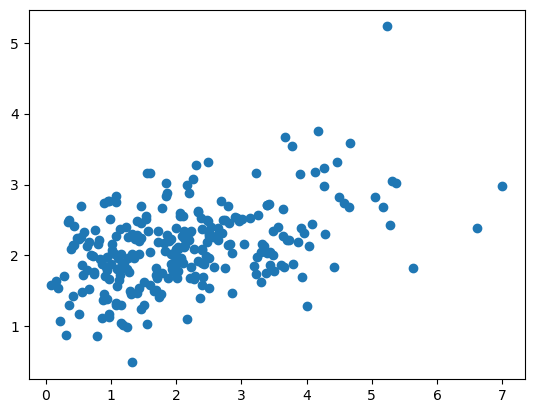

In [85]:
plt.scatter(y.values,predicted)

In [86]:
mses, r2s = [], []
for n_components in np.arange(x_t.shape[1]) + 1:
    pca = PCA(n_components)
    
    x_train = pca.fit_transform(x_t)
    x_test = pca.transform(x_t)
    linear_model = LinearRegression()
    linear_model.fit(x_train, y)
    preds = linear_model.predict(x_test)

    mse_pca = metrics.mean_squared_error(y, preds)
    r2_pca = metrics.r2_score(y, preds)
    
    mses.append(mse_pca)
    r2s.append(r2_pca)

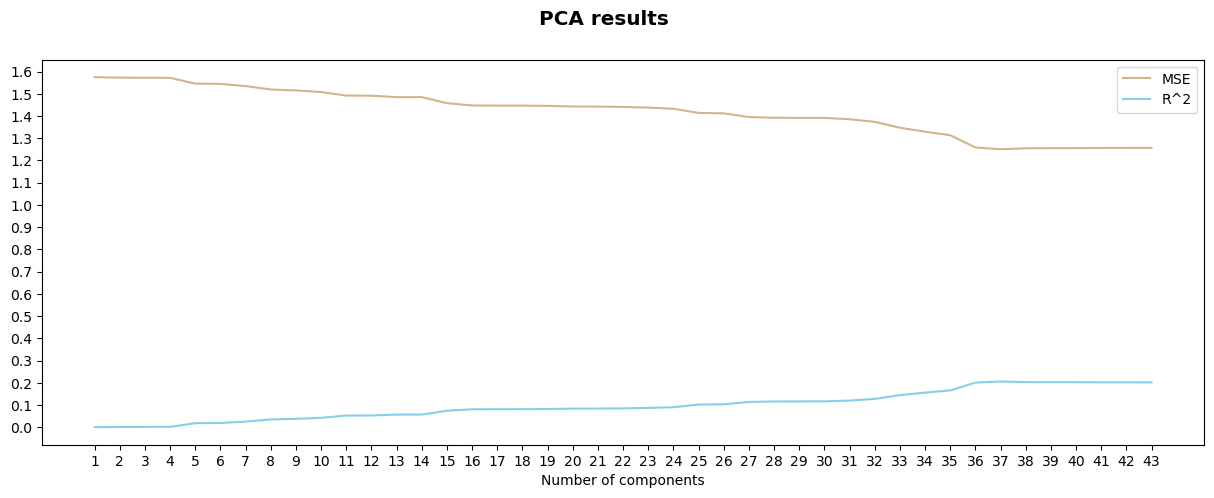

In [87]:
fig = plt.figure(figsize=(15,5))

plt.suptitle('PCA results', fontsize = 'x-large', fontweight = 'bold')
plt.plot(mses, label="MSE", color="tan")
plt.plot(r2s,  label="R^2", color="skyblue")
plt.xticks(np.arange(x_t.shape[1]), np.arange(1, x_t.shape[1] + 1))
plt.yticks(np.arange(44) * 0.1)
plt.axis('tight')
plt.xlabel('Number of components')

plt.legend()
plt.show()

## Lasso

### Básica

In [88]:
import warnings
warnings.filterwarnings("ignore")

In [89]:
dfl=dfo.copy()
dfl=dfl[dfl['area']>0.0]
dfl['area'] = dfl['area'].apply(lambda x: np.log(x+1))
X = dfl[['DC','DMC','RH','temp','rain','wind','ISI']].values.reshape(-1,7)
y = dfl['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)
print (X_train.shape, y_train.shape)

(216, 7) (216,)


Text(0.5, 1.0, 'Coeficientes del modelen funció de la regularizació')

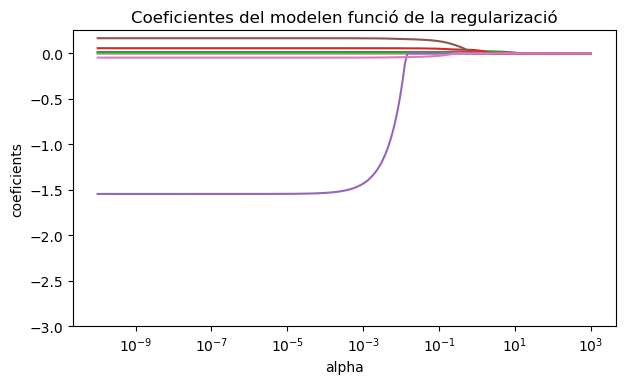

In [90]:
modelo = LassoCV(alphas = np.logspace(-10, 3, 200),normalize= True,cv = 10)
modelo.fit(X = X_train, y = y_train)
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-3,None])

ax.set_xlabel('alpha')
ax.set_ylabel('coeficients')
ax.set_title('Coeficientes del modelen funció de la regularizació')

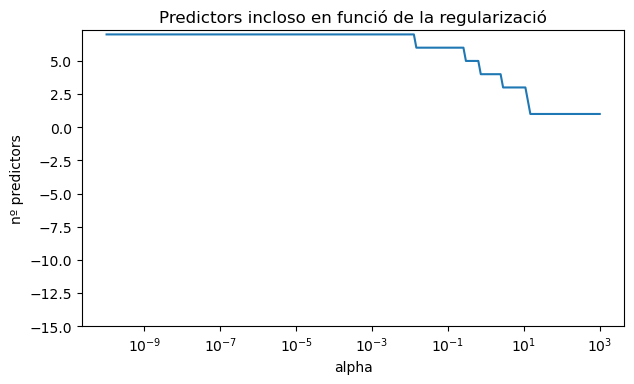

In [91]:
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictors')
ax.set_title('Predictors incloso en funció de la regularizació');

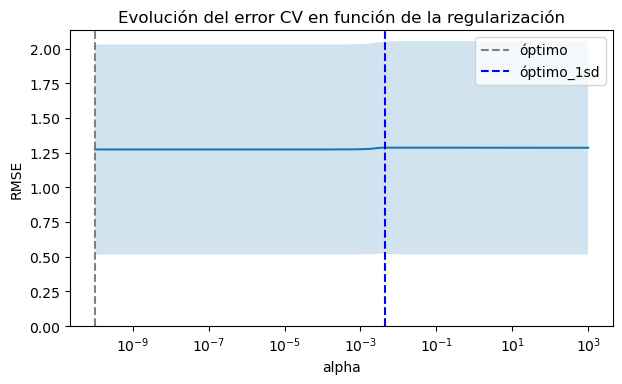

In [92]:
#Evolució de l'error en base a l'alpha
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [93]:
print(f"Millor alpha: {modelo.alpha_}")

Millor alpha: 1e-10


In [94]:
modelo = Lasso(alpha=1e-10, normalize=True)
modelo.fit(X_train, y_train)
print(modelo.coef_)

[-6.05645642e-04  4.46794312e-03 -1.08499964e-02 -2.70540063e-02
 -6.56622395e-01  3.04037789e-02 -3.07903166e-02]


In [95]:
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([2.00705791, 2.36116526, 1.71706644, 1.87595816, 2.0398432 ,
       2.14657396, 2.37911592, 2.1951815 , 2.3959078 , 2.31159801])

In [96]:
rmse_lasso = metrics.mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 1.3617738572044258


In [97]:
print("R score:",modelo.score(X_test, y_test))

R score: -0.38680273295804035


### One-hot

In [98]:
dflo=dfo.copy()

dflo = dflo[[ 'month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'rain', 'area']]
enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(dflo[['month']]).toarray())
df_OneHot = dflo.join(enc_df)
df_OneHot= df_OneHot[[ 'FFMC','DMC','DC','ISI','temp','RH','wind','rain','area',0,1,2,3,4,5,6,7,8,9,10,11]]

df_OneHot = df_OneHot.rename(columns={i: f"{i}" for i in range(0,12)})
df_OneHot

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,0,...,2,3,4,5,6,7,8,9,10,11
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0,...,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,...,0,0,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,...,0,0,0,0,0,0,0,0,1,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0,...,0,0,0,0,0,1,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,0,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,0,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,...,0,0,0,0,0,0,0,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
df_OneHot["area"]=df_OneHot["area"].apply(lambda x: np.log(x+1))
df_OneHot=df_OneHot[df_OneHot["area"]>0.00]

df_OneHot.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,0,...,2,3,4,5,6,7,8,9,10,11
138,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.307485,0,...,0,0,0,1,0,0,0,0,0,0
139,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.357674,0,...,0,0,0,0,0,0,0,0,0,1
140,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.385262,0,...,0,0,0,0,0,0,0,0,0,1
141,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.438255,0,...,0,0,0,0,0,0,0,0,0,0
142,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.476234,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
X = df_OneHot[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', '0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']].values.reshape(-1,20)
y = df_OneHot['area']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

Text(0.5, 1.0, 'Coeficients del modelo en funció de la regularizació')

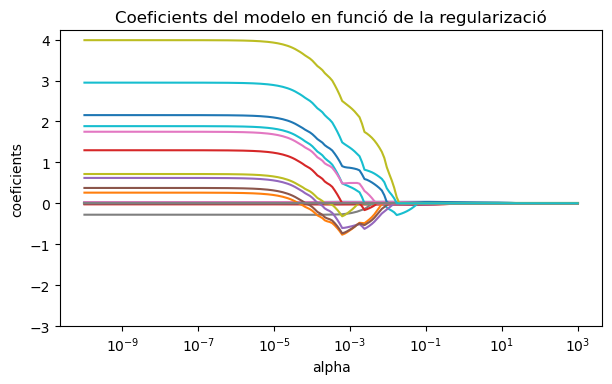

In [101]:
modelo =LassoCV(alphas = np.logspace(-10, 3, 200),normalize= True,cv = 10)
_ = modelo.fit(X = X_train, y = y_train)
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-3,None])

ax.set_xlabel('alpha')
ax.set_ylabel('coeficients')
ax.set_title('Coeficients del modelo en funció de la regularizació')

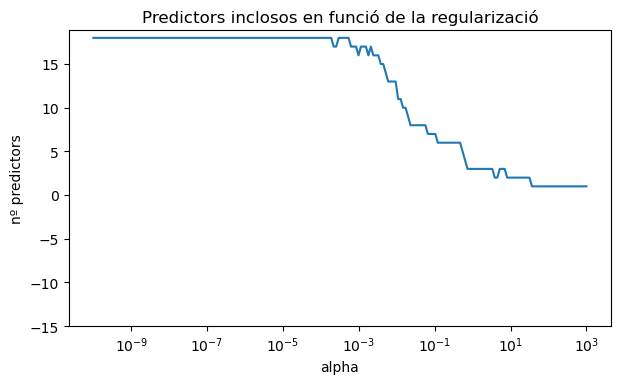

In [102]:
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictors')
ax.set_title('Predictors inclosos en funció de la regularizació');

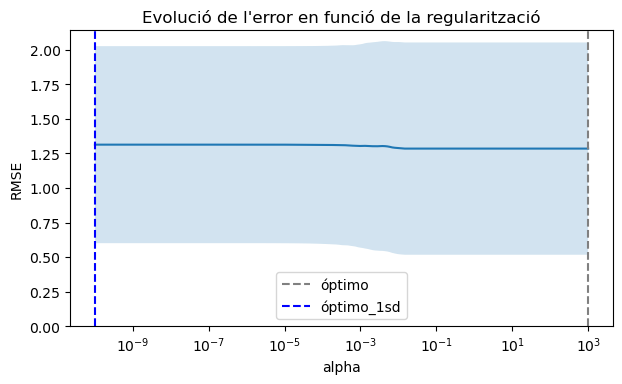

In [103]:
#Error segons l'alpha
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# canvi de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# model optim i primer std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# grafic error +- desviacio estandard
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title("Evolució de l'error en funció de la regularització")
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [104]:
print(f"Millor alpha: {modelo.alpha_}")
alphAA = modelo.alpha_

Millor alpha: 1000.0


In [105]:
modelo = Lasso(alpha=1000, normalize=True)
modelo.fit(X_train, y_train)
print(modelo.coef_)

[-0.  0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.
  0.  0.]


In [106]:
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]
rmse_lasso = metrics.mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")
print("R score:",modelo.score(X_test, y_test))


El error (rmse) de test es: 1.156685103730947
R score: -0.0005412286156536439


Podem veure que els resultats no son gens bons en base a que tots els coeficients son zero i que el $R^2$ es negatiu

## Regressió Logísitca

Mirarem seguint una mica l'idea de la gravetat d'un incendi si la logistica ens pot fer una predicció de si serà greu o no a partir d'una escala imposada per nosaltres. Això pot ser útil per la mobilització de recursos a un incendi per la seva extinció.

In [107]:
dfrl=dfo.copy()
def area_cat(area):
    if area <= 25.0:
        return 0
    else:
        return 1
dfrl['damage_category'] = dfrl['area'].apply(area_cat)
dfrl.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,0.100580
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,0.301063
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,0.000000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,0.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,1.000000


In [108]:
enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(dfrl[['day']]).toarray())
df_OneHot = dfrl.join(enc_df)
df_OneHot.pop('day')

df_OneHot = df_OneHot.rename(columns={ i: 'Day {}'.format(i) for i in range(0,7)})

enc = OneHotEncoder(handle_unknown='ignore', dtype=int)
enc_df = pd.DataFrame(enc.fit_transform(df_OneHot[['month']]).toarray())
df_OneHot = df_OneHot.join(enc_df)
df_OneHot.pop('month')

df_OneHot = df_OneHot.rename(columns={ i: 'Month {}'.format(i) for i in range(0,12)})
df_OneHot.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,...,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,...,0.017408,0.038685,0.003868,0.061896,0.032882,0.104449,0.003868,0.001934,0.029014,0.332689
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,...,0.130913,0.193029,0.062137,0.241199,0.178500,0.306138,0.062137,0.043980,0.168007,0.471632
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
y=df_OneHot.pop('damage_category')
df_OneHot.drop('area',axis=1)
y.describe()

count    517.000000
mean       0.100580
std        0.301063
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: damage_category, dtype: float64

In [110]:
x1=df_OneHot[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
x2=df_OneHot[['Day 0', 'Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5','Day 6','Month 0', 'Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5','Month 6', 'Month 7', 'Month 8', 'Month 9', 'Month 10', 'Month 11']]

x = standarize2(x1)
x= pd.concat([x, x2], axis=1)
x.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,Day 0,Day 1,...,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
count,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,517.000000,517.000000,...,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.199606e-14,-2.989227e-16,1.920235e-15,-7.945503e-16,4.346405e-16,1.619165e-16,-4.061870e-16,3.354828e-16,0.164410,0.143133,...,0.017408,0.038685,0.003868,0.061896,0.032882,0.104449,0.003868,0.001934,0.029014,0.332689
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.371006,0.350548,...,0.130913,0.193029,0.062137,0.241199,0.178500,0.306138,0.062137,0.043980,0.168007,0.471632
min,-1.303319e+01,-1.713948e+00,-2.177000e+00,-1.978662e+00,-2.874160e+00,-1.794899e+00,-2.019142e+00,-7.319742e-02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.055651e-02,-6.600260e-01,-4.443977e-01,-5.530598e-01,-5.836726e-01,-6.917863e-01,-7.354113e-01,-7.319742e-02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.730616e-01,-4.016365e-02,4.686651e-01,-1.363453e-01,7.075224e-02,-1.402302e-01,-9.824197e-03,-7.319742e-02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.085641e-01,4.922622e-01,6.690148e-01,3.900308e-01,6.735120e-01,5.338940e-01,4.925053e-01,-7.319742e-02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.006378e+00,2.817136e+00,1.260389e+00,1.032538e+01,2.481791e+00,3.414243e+00,3.004153e+00,2.155141e+01,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
LogReg=LogisticRegression()
idx = dfrl.sample(frac=0.7).index
x_tr = x[x.index.isin(idx)]
x_te = x[~x.index.isin(idx)]
y_tr = y[y.index.isin(idx)]
y_te = y[~y.index.isin(idx)]

In [112]:
scores=cross_val_score(LogReg,x_tr,y_tr,cv=7)
print('Cross-Validation scores',scores)

Cross-Validation scores [0.90384615 0.90384615 0.90384615 0.90384615 0.88461538 0.90196078
 0.90196078]


Els resultats semblen bons, així que anem a fer la matriu de confusió

In [113]:
LogReg.fit(x_tr,y_tr)
y_pred=LogReg.predict(x_te)
metrics.confusion_matrix(y_te,y_pred)

array([[139,   0],
       [ 16,   0]], dtype=int64)

Veiem que els resultats semblen bons perque hi ha molts zeros, pero no perque la regressió sigui bona de veritat. Ja que podem veure com ho classifica tot com zeros, incendis moderats.